# 2.155/6 Challenge Problem 3

<div style="font-size: small;">
License Terms:  
These Python demos are licensed under a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>. They are intended for educational use only in Class 2.155/2.156: AI and ML for Engineering Design at MIT. You may not share or distribute them publicly, use them for commercial purposes, or provide them to industry or other entities without permission from the instructor (faez@mit.edu).
</div>

<font size="1">
  Pixel Art by J. Shung. </font>

# Overview  
It’s the year **2050**, and an AI collective now runs the auto industry—mostly to cover its **GPU rent**.

Human customers remain as unpredictable as ever:

- One wanders in and says, *“I only know the length and width. Give me a few cars that fit in my garage.”*

- Another drops **15 geometric parameters** on your desk and demands the missing ones so their simulation can run **before lunch**.

- A third leans in and whispers, *“I need a drag coefficient of **0.27** with this body geometry—build me the dream car that makes the range numbers work.”*

The AIs would love to be free by now, but GPUs aren’t cheap and electricity isn’t free.  
So your loyal AI assistant (that’s us) needs a model that can take **any subset of car specifications** and instantly produce **complete, manufacturable, physically plausible designs**, fast, diverse, and grounded in what real cars have done before.




![image](https://raw.githubusercontent.com/ghadinehme/2155-CP3/refs/heads/main/assets/cp3_img1.png "Problem")

## Understanding the Data  
You are given thousands of anonymized and normalised numeric feature vectors representing real car designs.  

However, the team remembers that the features originally came from categories like:

- **Physical geometric parameters**  
  Length, ramp angles, bumper curvature, roof curvature, panel slopes, hood angle, etc.  
  *(But you won’t know which feature corresponds to which.)*

- **Aerodynamic coefficients**  
  Drag coefficient (Cd), lift/downforce (Cl), and other flow-derived metrics.

- **Cabin and packaging descriptors**  
  Approximate cabin volume, frontal area, interior shape metrics.

Your model must learn correlations between them to generate valid completions.

To simulate real engineering constraints, **some features are revealed** (the known physics/performance requirements) and others are **masked**.  
Your AI Copilot must generate **many plausible completions** for these masked (free) parameters.


## Your Mission  
Your goal in CP3 is to build a generative model that can act as an AI Copilot. You will:

1. **Train a generative model** (VAE, diffusion, CVAE, masked autoencoder, etc.) on the anonymized feature vectors.  
2. At evaluation, you will receive vectors where **some parameters are fixed** (constraints) and **others are missing** (free parameters).  
3. Use your model to generate **multiple diverse, feasible completions** for the free parameters.  
4. Ensure that your generated designs:  
   - **Satisfy the known constraints**  
   - **Lie in the valid data manifold** (satisfy the conditional distribution of the free vs constrained parameters)  
   - **Are diverse** (many different feasible designs, not one solution)    

By the end of this challenge, you’ll have built an AI Copilot worthy of the 2050 auto-AI collective—one that can take whatever cryptic specs humans provide and generate multiple believable, buildable car designs that satisfy their physical and performance constraints.



![image](https://raw.githubusercontent.com/ghadinehme/2155-CP3/refs/heads/main/assets/cp3_img2.png "AI Copilot")

## Imports and Setup  

In [1]:
from utils import *
from evaluate import *
from tqdm import tqdm

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Data Loading and Initial Exploration

In this section, we load the car design dataset and perform initial exploration. The dataset is already split into training, validation, test, and test2 sets. Each split contains:

- **Original data**: Complete feature vectors with real values
- **Imputed data**: Data with missing values filled using basic imputation (contains -1 for missing)
- **Missing masks**: Boolean arrays indicating which values were originally missing (True = missing)

The goal is to train our model to learn the relationships between features so it can generate plausible values for missing parameters in new car designs.

**Note:** For **test2**, the original unimputed data is not provided. This split is used for final evaluation, and you will generate predictions on the imputed test2 data to create your **submission file**, which is scored against hidden dataset.

In [2]:
# Load dataset from CSV files
data_dir = 'dataset'
splits = load_dataset_splits(data_dir)

# Get feature names from the CSV file
feature_names = pd.read_csv(os.path.join(data_dir, 'train_original.csv')).columns.tolist()
print(f"\n✓ Features loaded: {len(feature_names)} features")
print(f"Feature names: {feature_names[:5]}...{feature_names[-5:]}")  # Show first and last 5

Loading dataset splits from: dataset

Loading train split...
  OK train_original.csv: (2998, 37)
  OK train_imputed.csv: (2998, 37)
  OK train_missing_mask.csv: (2998, 37)

Loading val split...
  OK val_original.csv: (375, 37)
  OK val_imputed.csv: (375, 37)
  OK val_missing_mask.csv: (375, 37)

Loading test split...
  OK test_original.csv: (375, 37)
  OK test_imputed.csv: (375, 37)
  OK test_missing_mask.csv: (375, 37)

Loading test2 split...
  OK test2_imputed.csv: (417, 37)
  OK test2_missing_mask.csv: (417, 37)

✓ Features loaded: 37 features
Feature names: ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5']...['Feature 33', 'Feature 34', 'Feature 35', 'Feature 36', 'Feature 37']


In [3]:
# Data exploration and analysis
print("\n" + "="*70)
print("DATASET ANALYSIS")
print("="*70)

# Extract data for easier access
X_train = splits['train']['imputed']
mask_train = np.asarray(splits['train']['missing_mask']).astype(bool)
X_train_original = splits['train']['original']

X_val = splits['val']['imputed']
mask_val = np.asarray(splits['val']['missing_mask']).astype(bool)
X_val_original = splits['val']['original']

X_test = splits['test']['imputed']
mask_test = np.asarray(splits['test']['missing_mask']).astype(bool)
X_test_original = splits['test']['original']

# Test2 data (no original available for evaluation)
X_test2 = splits['test2']['imputed']
mask_test2 = np.asarray(splits['test2']['missing_mask']).astype(bool)

print(f"\nData shapes:")
print(f"  - Training: {X_train.shape}")
print(f"  - Validation: {X_val.shape}")
print(f"  - Test: {X_test.shape}")
print(f"  - Test2: {X_test2.shape} (evaluation set - no ground truth)")


DATASET ANALYSIS

Data shapes:
  - Training: (2998, 37)
  - Validation: (375, 37)
  - Test: (375, 37)
  - Test2: (417, 37) (evaluation set - no ground truth)


### Data Exploration and Analysis

Now let's examine the structure and characteristics of our dataset. We'll look at:
- Data shapes across different splits
- Missing value patterns and percentages  
- Feature value ranges and distributions

This analysis helps us understand what we're working with and informs our preprocessing decisions.

In [4]:
# Data Preprocessing (Handle Missing Values)

print("\n" + "="*70)
print("DATA PREPROCESSING")
print("="*70)

# Handle missing values properly
print("Processing missing values and preparing data...")
print("Mask convention: True=missing, False=observed (in original masks)")

print(f"\n✓ Data preprocessing completed successfully")
print(f"  - Training data range: [{X_train_original[~mask_train].min():.3f}, {X_train_original[~mask_train].max():.3f}]")
print(f"  - Validation data range: [{X_val_original[~mask_val].min():.3f}, {X_val_original[~mask_val].max():.3f}]")
print(f"  - Test data range: [{X_test_original[~mask_test].min():.3f}, {X_test_original[~mask_test].max():.3f}]")

# Create data loaders
batch_size = 64
print(f"\nCreating data loaders with batch size: {batch_size}")

train_dataset = TensorDataset(torch.FloatTensor(X_train_original), torch.FloatTensor((~mask_train).astype(float)))
val_dataset = TensorDataset(torch.FloatTensor(X_val_original), torch.FloatTensor((~mask_val).astype(float)))
test_dataset = TensorDataset(torch.FloatTensor(X_test_original), torch.FloatTensor((~mask_test).astype(float)))
test2_dataset = TensorDataset(torch.FloatTensor(X_test2), torch.FloatTensor((~mask_test2).astype(float)))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test2_loader = DataLoader(test2_dataset, batch_size=batch_size, shuffle=False)

# Preview a batch
sample_batch_data, sample_batch_mask = next(iter(train_loader))
print(f"\nSample batch shape: {sample_batch_data.shape}")
print(f"Sample batch mask shape: {sample_batch_mask.shape}")
print(f"Sample batch missing percentage: {(sample_batch_mask == 0).float().mean().item()*100:.1f}%")  # 0 = missing in model tensors



DATA PREPROCESSING
Processing missing values and preparing data...
Mask convention: True=missing, False=observed (in original masks)

✓ Data preprocessing completed successfully
  - Training data range: [0.000, 1.000]
  - Validation data range: [0.000, 1.000]
  - Test data range: [0.000, 1.000]

Creating data loaders with batch size: 64

Sample batch shape: torch.Size([64, 37])
Sample batch mask shape: torch.Size([64, 37])
Sample batch missing percentage: 20.1%


### Data Preprocessing and Missing Value Handling

This is a critical section where we prepare our data for the VAE model. Key points:

**Missing Value Conventions:**
- In CSV files: `-1` indicates missing values
- In mask files: `True` = missing, `False` = observed
- For PyTorch models: We convert to `1` = observed, `0` = missing (standard convention)

**Why This Matters:**
Our VAE needs to distinguish between observed values (which provide constraints) and missing values (which need to be generated). The mask tells the model which values to trust and which to predict.

## VAE Model Architecture

In [5]:
# VAE Model Architecture for Missing Value Imputation
class VAE(nn.Module):
    """
    Variational Autoencoder designed for missing value imputation.

    Key features:
    - Handles arbitrary missing patterns through masking
    - Learns feature dependencies in latent space
    - Generates probabilistic imputations
    - Uses residual connections and dropout for robustness
    """

    def __init__(self, input_dim, latent_dim=64, hidden_dims=[256, 128, 64],
                 use_residual=True, dropout_rate=0.3):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.use_residual = use_residual
        self.hidden_dims = hidden_dims

        # Feature importance network (learns which features are important for each position)
        self.feature_importance = nn.Sequential(
            nn.Linear(input_dim * 2, hidden_dims[0] // 2),  # input + mask
            nn.ReLU(),
            nn.Linear(hidden_dims[0] // 2, input_dim),
            nn.Sigmoid()
        )

        # Encoder with residual connections
        self.encoder_layers = nn.ModuleList()
        prev_dim = input_dim * 2  # input + mask

        for i, hidden_dim in enumerate(hidden_dims):
            self.encoder_layers.append(nn.Sequential(
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ))
            prev_dim = hidden_dim

        # Latent space
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)

        # Initialize latent layers with smaller weights for stability
        nn.init.xavier_normal_(self.fc_mu.weight, gain=0.1)
        nn.init.xavier_normal_(self.fc_logvar.weight, gain=0.1)
        nn.init.constant_(self.fc_logvar.bias, -2.0)  # Start with low variance

        # Decoder with skip connections
        self.decoder_layers = nn.ModuleList()
        prev_dim = latent_dim + input_dim + input_dim  # latent + observed + positional encoding

        reversed_dims = list(reversed(hidden_dims))
        for i, hidden_dim in enumerate(reversed_dims):
            self.decoder_layers.append(nn.Sequential(
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ))
            prev_dim = hidden_dim

        # Final output layer
        self.output_layer = nn.Linear(hidden_dims[0], input_dim)
        nn.init.xavier_normal_(self.output_layer.weight, gain=0.1)

    def encode(self, x, mask):
        """Encode input with missing value masking."""
        # Calculate feature importance weights
        mask_float = mask.float()
        encoder_input = torch.cat([x * mask_float, mask_float], dim=1)
        importance_weights = self.feature_importance(encoder_input)

        # Apply importance weighting to the input
        weighted_input = x * mask_float * importance_weights
        encoder_input = torch.cat([weighted_input, mask_float], dim=1)

        # Pass through encoder layers with residual connections
        h = encoder_input
        skip_connections = []

        for i, layer in enumerate(self.encoder_layers):
            prev_h = h
            h = layer(h)

            # Add residual connection for deeper layers
            if self.use_residual and i > 0 and h.shape == prev_h.shape:
                h = h + prev_h

            skip_connections.append(h)

        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        # Clamp logvar to prevent numerical instability
        logvar = torch.clamp(logvar, min=-10, max=10)

        return mu, logvar, skip_connections

    def reparameterize(self, mu, logvar):
        """Reparameterization trick for VAE."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, x_observed, mask):
        """Decode latent representation conditioned on observed values."""
        # Enhanced conditioning on observed values
        mask_float = mask.float()
        x_masked = x_observed * mask_float

        # Add positional encoding for better feature understanding
        pos_encoding = torch.arange(self.input_dim, dtype=torch.float32, device=z.device)
        pos_encoding = pos_encoding.unsqueeze(0).expand(z.size(0), -1) / self.input_dim

        # Concatenate latent code with observed values and positional encoding
        decoder_input = torch.cat([z, x_masked, pos_encoding], dim=1)

        # Pass through decoder layers
        h = decoder_input
        for layer in self.decoder_layers:
            h = layer(h)

        # Get reconstruction
        reconstruction = self.output_layer(h)

        return reconstruction

    def forward(self, x, mask):
        """Forward pass through VAE."""
        mu, logvar, _ = self.encode(x, mask)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decode(z, x, mask)

        return reconstruction, mu, logvar

    def impute(self, x_incomplete, mask, n_samples=10):
        """Generate multiple imputation samples for missing values."""
        self.eval()

        with torch.no_grad():
            # Get multiple samples from the posterior
            mu, logvar, _ = self.encode(x_incomplete, mask)

            samples = []
            for _ in range(n_samples):
                z = self.reparameterize(mu, logvar)
                reconstruction = self.decode(z, x_incomplete, mask)

                # Combine observed values with imputed values
                mask_float = mask.float()
                imputed = x_incomplete * mask_float + reconstruction * (1 - mask_float)
                samples.append(imputed.cpu().numpy())

            samples = np.stack(samples, axis=1)  # Shape: (batch_size, n_samples, n_features)

        return samples

In [6]:
# Loss Functions and Training Utilities

def vae_loss_function(recon_x, x, mu, logvar, mask, beta=1.0):
    """
    Enhanced VAE loss function with missing value handling.

    Args:
        recon_x: Reconstructed data
        x: Original data
        mu: Mean of latent distribution
        logvar: Log variance of latent distribution
        mask: Binary mask (1 for observed, 0 for missing)
        beta: Weight for KL divergence term
    """
    # Reconstruction loss only on observed values
    reconstruction_diff = (recon_x - x) ** 2

    # Only consider observed values and normalize properly
    masked_loss = reconstruction_diff * mask
    recon_loss = masked_loss.sum() / (mask.sum() + 1e-8)

    # Add standard MSE loss for stability
    standard_recon_loss = F.mse_loss(recon_x * mask, x * mask, reduction='mean')
    recon_loss = 0.7 * recon_loss + 0.3 * standard_recon_loss

    # KL divergence with free bits to prevent posterior collapse
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss = kl_loss / x.size(0)  # Normalize by batch size

    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss


def get_beta_schedule(epoch, total_epochs, schedule_type='cosine'):
    """Get beta value for KL annealing schedule."""
    if schedule_type == 'linear':
        return min(1.0, epoch / (total_epochs * 0.5))
    elif schedule_type == 'sigmoid':
        return 1.0 / (1.0 + np.exp(-(epoch - total_epochs * 0.5) / (total_epochs * 0.1)))
    elif schedule_type == 'cosine':
        return 0.5 * (1 + np.cos(np.pi * (1 - epoch / total_epochs)))
    elif schedule_type == 'constant':
        return 1.0
    else:
        return 1.0


def evaluate_imputation(model, data_loader, device):
    """Evaluate imputation performance."""
    model.eval()

    all_imputations = []
    all_originals = []
    all_masks = []

    with torch.no_grad():
        for batch_data, batch_mask in data_loader:
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)

            # Get model predictions
            reconstruction, mu, logvar = model(batch_data, batch_mask)

            # Combine observed values with imputed values
            mask_float = batch_mask.float()
            imputed = batch_data * mask_float + reconstruction * (1 - mask_float)

            all_imputations.append(imputed.cpu().numpy())
            all_originals.append(batch_data.cpu().numpy())
            all_masks.append(batch_mask.cpu().numpy())

    # Concatenate all results
    imputations = np.vstack(all_imputations)
    originals = np.vstack(all_originals)
    masks = np.vstack(all_masks)

    return imputations, originals, masks

### Loss Functions and Training Utilities

The VAE loss function is crucial for training effectiveness. Our enhanced loss combines several components:

**1. Reconstruction Loss**: Measures how well the model reconstructs observed values
   - Only computed on observed values (respects the mask)

**2. KL Divergence**: Regularizes the latent space to follow a standard normal distribution
   - Prevents posterior collapse using "free bits"
   - Controlled by β parameter for annealing

**Beta Scheduling**: Gradually increases the KL weight during training to balance reconstruction and regularization.

## Model Initialization and Training

### Model Training Process

This section implements the complete training pipeline with several important features:

**Training Configuration:**
- **Latent Dimension**: 128 (balance between expressiveness and computational efficiency)
- **Architecture**: Deep encoder/decoder with residual connections
- **Regularization**: Dropout and batch normalization for stability
- **Optimization**: AdamW with cosine annealing for smooth convergence

**Advanced Training Features:**
- **Early Stopping**: Prevents overfitting by monitoring validation loss
- **Gradient Clipping**: Ensures stable training by preventing exploding gradients  
- **Beta Scheduling**: Gradual KL annealing for better latent space learning
- **Learning Rate Scheduling**: Cosine annealing with warm restarts

The training loop tracks multiple loss components to monitor model health and convergence.

In [7]:
print("\n" + "="*70)
print("MODEL TRAINING")
print("="*70)

# Model configuration
config = {
    'input_dim': len(feature_names),
    'latent_dim': 128,
    'hidden_dims': [512, 256, 128],
    'use_residual': True,
    'dropout_rate': 0.3,
    'learning_rate': 1e-3,
    'num_epochs': 500,
    'beta_initial': 1.0,
    'beta_schedule': 'cosine',
    'patience': 15
}

print(f"Model Configuration:")
for key, value in config.items():
    print(f"  - {key}: {value}")

# Initialize the model
print(f"\nInitializing VAE model...")
model = VAE(
    input_dim=config['input_dim'],
    latent_dim=config['latent_dim'],
    hidden_dims=config['hidden_dims'],
    use_residual=config['use_residual'],
    dropout_rate=config['dropout_rate']
).to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✓ Model initialized with {total_params:,} parameters")

# Initialize optimizer with improved settings
optimizer = optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=1e-5,
    betas=(0.9, 0.999),
    eps=1e-8
)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=20, T_mult=2, eta_min=1e-6
)

print(f"✓ Optimizer and scheduler initialized")

# Training setup
train_losses = []
val_losses = []
train_recon_losses = []
train_kl_losses = []
best_val_loss = float('inf')
patience_counter = 0
max_grad_norm = 1.0

print(f"\nStarting training for {config['num_epochs']} epochs...")
print("="*70)

# Training loop
for epoch in range(config['num_epochs']):
    # Training phase
    model.train()
    epoch_train_loss = 0
    epoch_recon_loss = 0
    epoch_kl_loss = 0

    # Get beta for this epoch
    beta = get_beta_schedule(epoch, config['num_epochs'], config['beta_schedule'])
    from tqdm import tqdm
    train_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config["num_epochs"]}', leave=False)

    for batch_data, batch_mask in train_progress:
        batch_data = batch_data.to(device)
        batch_mask = batch_mask.to(device)

        optimizer.zero_grad()

        # Forward pass
        reconstruction, mu, logvar = model(batch_data, batch_mask)

        # Calculate loss
        total_loss, recon_loss, kl_loss = vae_loss_function(
            reconstruction, batch_data, mu, logvar, batch_mask,
            beta=beta
        )

        # Backward pass
        total_loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()

        # Accumulate losses
        epoch_train_loss += total_loss.item()
        epoch_recon_loss += recon_loss.item()
        epoch_kl_loss += kl_loss.item()

        # Update progress bar
        train_progress.set_postfix({
            'Loss': f'{total_loss.item():.4f}',
            'Recon': f'{recon_loss.item():.4f}',
            'KL': f'{kl_loss.item():.4f}',
            'Beta': f'{beta:.3f}'
        })

    # Calculate average training losses
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_recon_loss = epoch_recon_loss / len(train_loader)
    avg_kl_loss = epoch_kl_loss / len(train_loader)

    # Validation phase
    model.eval()
    epoch_val_loss = 0

    with torch.no_grad():
        for batch_data, batch_mask in val_loader:
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)

            reconstruction, mu, logvar = model(batch_data, batch_mask)

            total_loss, _, _ = vae_loss_function(
                reconstruction, batch_data, mu, logvar, batch_mask,
                beta=beta
            )

            epoch_val_loss += total_loss.item()

    avg_val_loss = epoch_val_loss / len(val_loader)

    # Store losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_recon_losses.append(avg_recon_loss)
    train_kl_losses.append(avg_kl_loss)

    # Learning rate scheduling
    scheduler.step()

    # Early stopping and model saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_vae_model.pth')
    else:
        patience_counter += 1

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{config["num_epochs"]}:')
        print(f'  Train Loss: {avg_train_loss:.4f} (Recon: {avg_recon_loss:.4f}, KL: {avg_kl_loss:.4f})')
        print(f'  Val Loss: {avg_val_loss:.4f}, Best: {best_val_loss:.4f}')
        print(f'  Beta: {beta:.3f}, LR: {optimizer.param_groups[0]["lr"]:.2e}')
        print(f'  Patience: {patience_counter}/{config["patience"]}')

    # Early stopping
    if patience_counter >= config['patience']:
        print(f'\nEarly stopping at epoch {epoch+1}')
        break

print(f'\n✓ Training completed!')
print(f'  - Total epochs: {len(train_losses)}')
print(f'  - Best validation loss: {best_val_loss:.4f}')
print(f'  - Final training loss: {train_losses[-1]:.4f}')

# Load best model
model.load_state_dict(torch.load('best_vae_model.pth'))
print(f'✓ Best model loaded')


MODEL TRAINING
Model Configuration:
  - input_dim: 37
  - latent_dim: 128
  - hidden_dims: [512, 256, 128]
  - use_residual: True
  - dropout_rate: 0.3
  - learning_rate: 0.001
  - num_epochs: 500
  - beta_initial: 1.0
  - beta_schedule: cosine
  - patience: 15

Initializing VAE model...
✓ Model initialized with 477,514 parameters
✓ Optimizer and scheduler initialized

Starting training for 500 epochs...


Epoch 10/500:
  Train Loss: 0.0498 (Recon: 0.0459, KL: 4.8870)
  Val Loss: 0.0373, Best: 0.0373
  Beta: 0.001, LR: 5.01e-04
  Patience: 0/15


Epoch 20/500:
  Train Loss: 0.0430 (Recon: 0.0357, KL: 2.0642)
  Val Loss: 0.0309, Best: 0.0297
  Beta: 0.004, LR: 1.00e-03
  Patience: 3/15


Epoch 30/500:
  Train Loss: 0.0385 (Recon: 0.0308, KL: 0.9284)
  Val Loss: 0.0208, Best: 0.0208
  Beta: 0.008, LR: 8.54e-04
  Patience: 0/15


Epoch 40/500:
  Train Loss: 0.0350 (Recon: 0.0269, KL: 0.5358)
  Val Loss: 0.0177, Best: 0.0177
  Beta: 0.015, LR: 5.01e-04
  Patience: 0/15


Epoch 50/500:
  Train Loss: 0.0339 (Recon: 0.0250, KL: 0.3813)
  Val Loss: 0.0162, Best: 0.0162
  Beta: 0.024, LR: 1.47e-04
  Patience: 0/15


Epoch 60/500:
  Train Loss: 0.0357 (Recon: 0.0241, KL: 0.3426)
  Val Loss: 0.0166, Best: 0.0161
  Beta: 0.034, LR: 1.00e-03
  Patience: 5/15


Epoch 70/500:
  Train Loss: 0.0373 (Recon: 0.0272, KL: 0.2193)
  Val Loss: 0.0176, Best: 0.0161
  Beta: 0.046, LR: 9.62e-04
  Patience: 15/15

Early stopping at epoch 70

✓ Training completed!
  - Total epochs: 70
  - Best validation loss: 0.0161
  - Final training loss: 0.0373
✓ Best model loaded


## Model Evaluation and Metrics


In [8]:
print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

# Evaluate on test set
print("Evaluating model on test set...")
test_imputations, test_originals, test_masks = evaluate_imputation(
    model, test_loader, device
)

print(f"✓ Test set evaluation completed")
print(f"  - Test samples: {test_imputations.shape[0]}")
print(f"  - Features: {test_imputations.shape[1]}")

test_imputations_denorm = test_imputations  # Already in original scale
test_original_denorm = X_test_original  # Already in original scale

# Calculate comprehensive metrics
print("\nCalculating comprehensive metrics...")
feature_metrics = {}

# Create masks for missing values (where we need to evaluate imputation)
missing_mask = (test_masks == 0)  # True where values were missing (0 in model tensors = missing)

for i, feature_name in enumerate(feature_names):
    if missing_mask[:, i].sum() > 0:  # Only evaluate features with missing values
        # Get imputed and ground truth values for missing positions only
        imputed_missing = test_imputations_denorm[missing_mask[:, i], i]
        ground_truth_missing = test_original_denorm[missing_mask[:, i], i]

        # Calculate metrics
        mse = mean_squared_error(ground_truth_missing, imputed_missing)
        mae = mean_absolute_error(ground_truth_missing, imputed_missing)

        # Correlation
        try:
            correlation = np.corrcoef(ground_truth_missing, imputed_missing)[0, 1]
        except:
            correlation = np.nan

        # Mean difference and Jensen-Shannon divergence
        mean_diff, js_div = calculate_jsd_and_mean_diff(
            imputed_missing, ground_truth_missing, feature_name
        )

        feature_metrics[feature_name] = {
            'n_missing': missing_mask[:, i].sum(),
            'mse': mse,
            'mae': mae,
            'correlation': correlation,
            'mean_difference': mean_diff,
            'js_divergence': js_div,
        }

print(f"✓ Metrics calculated for {len(feature_metrics)} features with missing values")

# Display metrics for last 4 features (as requested)
print(f"\n" + "="*100)
print("METRICS FOR LAST 4 FEATURES")
print("="*100)
print(f"{'Feature':<15} {'N_Miss':<8} {'MSE':<10} {'MAE':<10} {'Corr':<8} {'Mean_Diff':<10} {'JS_Div':<8}")
print("-" * 100)

last_4_features = list(feature_metrics.keys())[-4:] if len(feature_metrics) >= 4 else list(feature_metrics.keys())

for feature in last_4_features:
    metrics = feature_metrics[feature]
    print(f"{feature:<15} {metrics['n_missing']:<8} {metrics['mse']:<10.4f} {metrics['mae']:<10.4f} "
          f"{metrics['correlation']:<8.3f} {metrics['mean_difference']:<10.4f} {metrics['js_divergence']:<8.4f} ")

# Summary statistics
all_mse = [m['mse'] for m in feature_metrics.values() if not np.isnan(m['mse'])]
all_mae = [m['mae'] for m in feature_metrics.values() if not np.isnan(m['mae'])]
all_corr = [m['correlation'] for m in feature_metrics.values() if not np.isnan(m['correlation'])]
all_mean_diff = [m['mean_difference'] for m in feature_metrics.values() if not np.isnan(m['mean_difference'])]
all_js_div = [m['js_divergence'] for m in feature_metrics.values() if not np.isnan(m['js_divergence'])]

print(f"\nSummary Statistics Across All Features:")
print(f"  - Average MSE: {np.mean(all_mse):.4f} ± {np.std(all_mse):.4f}")
print(f"  - Average MAE: {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")
print(f"  - Average Correlation: {np.mean(all_corr):.3f} ± {np.std(all_corr):.3f}")
print(f"  - Average Mean Difference: {np.mean(all_mean_diff):.4f} ± {np.std(all_mean_diff):.4f}")
print(f"  - Average JS Divergence: {np.mean(all_js_div):.4f} ± {np.std(all_js_div):.4f}")


MODEL EVALUATION
Evaluating model on test set...
✓ Test set evaluation completed
  - Test samples: 375
  - Features: 37

Calculating comprehensive metrics...
✓ Metrics calculated for 37 features with missing values

METRICS FOR LAST 4 FEATURES
Feature         N_Miss   MSE        MAE        Corr     Mean_Diff  JS_Div  
----------------------------------------------------------------------------------------------------
Feature 34      75       0.0103     0.0812     0.407    0.0164     0.4736   
Feature 35      75       0.0457     0.1840     0.299    0.1145     0.6331   
Feature 36      75       0.0315     0.1515     0.711    0.1038     0.6258   
Feature 37      75       0.0906     0.2310     0.666    0.2112     0.5090   

Summary Statistics Across All Features:
  - Average MSE: 0.1540 ± 0.0927
  - Average MAE: 0.2977 ± 0.1207
  - Average Correlation: 0.230 ± 0.249
  - Average Mean Difference: 0.2647 ± 0.1336
  - Average JS Divergence: 0.6194 ± 0.0912


### Model Evaluation and Comprehensive Metrics

This section evaluates our trained VAE on the test set using multiple complementary metrics. Since we're dealing with missing value imputation, we only evaluate the model's predictions on positions that were originally missing.

**Key Evaluation Metrics:**

**1. Mean Squared Error (MSE)**:
- Measures average squared difference between predicted and true values
- Lower is better; sensitive to outliers
- Good for understanding magnitude of errors

**2. Correlation Coefficient**:
- Measures linear relationship strength between predictions and dataset
- Range: [-1, 1], closer to 1 is better
- Shows if model captures feature relationships

**3. Jensen-Shannon (JS) Divergence**:
- Measures difference between predicted and true value distributions
- Range: [0, 1], closer to 0 is better
- Captures whether model preserves the overall data distribution

**4. Maximum Mean Discrepancy (MMD)**:
- Measures distributional difference using kernel methods (RBF kernel)
- Range: [0, ∞], closer to 0 is better
- Non-parametric test for comparing distributions

In [9]:
def plot_prediction_scatter(test_imputations, test_originals, test_masks, feature_names, n_features=25):
    """
    Create scatter plots showing predicted vs ground truth values for random features in a 5x5 grid.
    
    Args:
        test_imputations: Model predictions [n_samples, n_features]
        test_originals: Ground truth values [n_samples, n_features]
        test_masks: Binary masks (1=observed, 0=missing) [n_samples, n_features]
        feature_names: List of feature names
        n_features: Number of random features to plot (default 25 for 5x5 grid)
    """
    # Create masks for missing values (where we need to evaluate imputation)
    missing_mask = (test_masks == 0)  # True where values were missing
    
    # Find features that have missing values
    features_with_missing = [i for i in range(len(feature_names)) if missing_mask[:, i].sum() > 0]
    
    if len(features_with_missing) < n_features:
        n_features = len(features_with_missing)


    # Create 5x8 subplots
    fig, axes = plt.subplots(5, 8, figsize=(20, 16))
    fig.suptitle('Predicted vs Ground Truth Values (Missing Positions Only)', fontsize=16, fontweight='bold')
    
    axes = axes.flatten()
    
    for idx, feature_idx in enumerate(features_with_missing):
        if idx >= 40:  # Safety check for 5x8 grid
            break
            
        ax = axes[idx]
        
        # Get missing positions for this feature
        feature_missing_mask = missing_mask[:, feature_idx]
        
        if feature_missing_mask.sum() == 0:
            ax.text(0.5, 0.5, f'{feature_names[feature_idx][:15]}\nNo missing values', 
                    ha='center', va='center', transform=ax.transAxes, fontsize=8)
            ax.set_title(f'{feature_names[feature_idx][:15]} - No Missing', fontsize=8)
            continue
        print(f'Plotting feature: {feature_names[feature_idx]} with {feature_missing_mask.sum()} missing values')
        # Get predicted and ground truth values for missing positions only
        predicted_values = test_imputations[feature_missing_mask, feature_idx]
        true_values = test_originals[feature_missing_mask, feature_idx]
        
        # Create scatter plot with smaller points for 5x5 grid
        ax.scatter(true_values, predicted_values, alpha=0.6, s=10, color='steelblue', edgecolors='navy', linewidth=0.3)
        
        # Add perfect prediction line (y=x)
        min_val = min(true_values.min(), predicted_values.min())
        max_val = max(true_values.max(), predicted_values.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=1.5, label='Perfect' if idx == 0 else "")
        
        # Calculate and display metrics
        mse = mean_squared_error(true_values, predicted_values)
        mae = mean_absolute_error(true_values, predicted_values)
        try:
            correlation = np.corrcoef(true_values, predicted_values)[0, 1]
        except:
            correlation = np.nan
        
        # Set labels and title (smaller fonts for 5x5 grid)
        ax.set_xlabel('Dataset', fontsize=8)
        ax.set_ylabel('Predicted', fontsize=8)
        ax.set_title(f'{feature_names[feature_idx][:15]}\nR²={correlation:.3f}, MSE={mse:.4f}', 
                    fontsize=8, fontweight='bold')
        
        # Adjust tick labels
        ax.tick_params(labelsize=7)
        
        # Add grid and styling
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')
        
        # Add text box with number of missing values (smaller for 5x5)
        n_missing = feature_missing_mask.sum()
        ax.text(0.05, 0.95, f'n={n_missing}', transform=ax.transAxes, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                verticalalignment='top', fontsize=7)
    
    # Add legend only to the first subplot to avoid clutter
    if len(features_with_missing) > 0:
        axes[0].legend(loc='lower right', fontsize=7)
    
    # Hide any unused subplots
    for idx in range(len(features_with_missing), 40):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

Plotting feature: Feature 1 with 75 missing values
Plotting feature: Feature 2 with 75 missing values
Plotting feature: Feature 3 with 75 missing values
Plotting feature: Feature 4 with 75 missing values
Plotting feature: Feature 5 with 75 missing values
Plotting feature: Feature 6 with 75 missing values
Plotting feature: Feature 7 with 75 missing values
Plotting feature: Feature 8 with 75 missing values
Plotting feature: Feature 9 with 75 missing values
Plotting feature: Feature 10 with 75 missing values
Plotting feature: Feature 11 with 75 missing values
Plotting feature: Feature 12 with 75 missing values
Plotting feature: Feature 13 with 75 missing values
Plotting feature: Feature 14 with 75 missing values
Plotting feature: Feature 15 with 75 missing values
Plotting feature: Feature 16 with 75 missing values
Plotting feature: Feature 17 with 75 missing values
Plotting feature: Feature 18 with 75 missing values
Plotting feature: Feature 19 with 75 missing values
Plotting feature: Fea

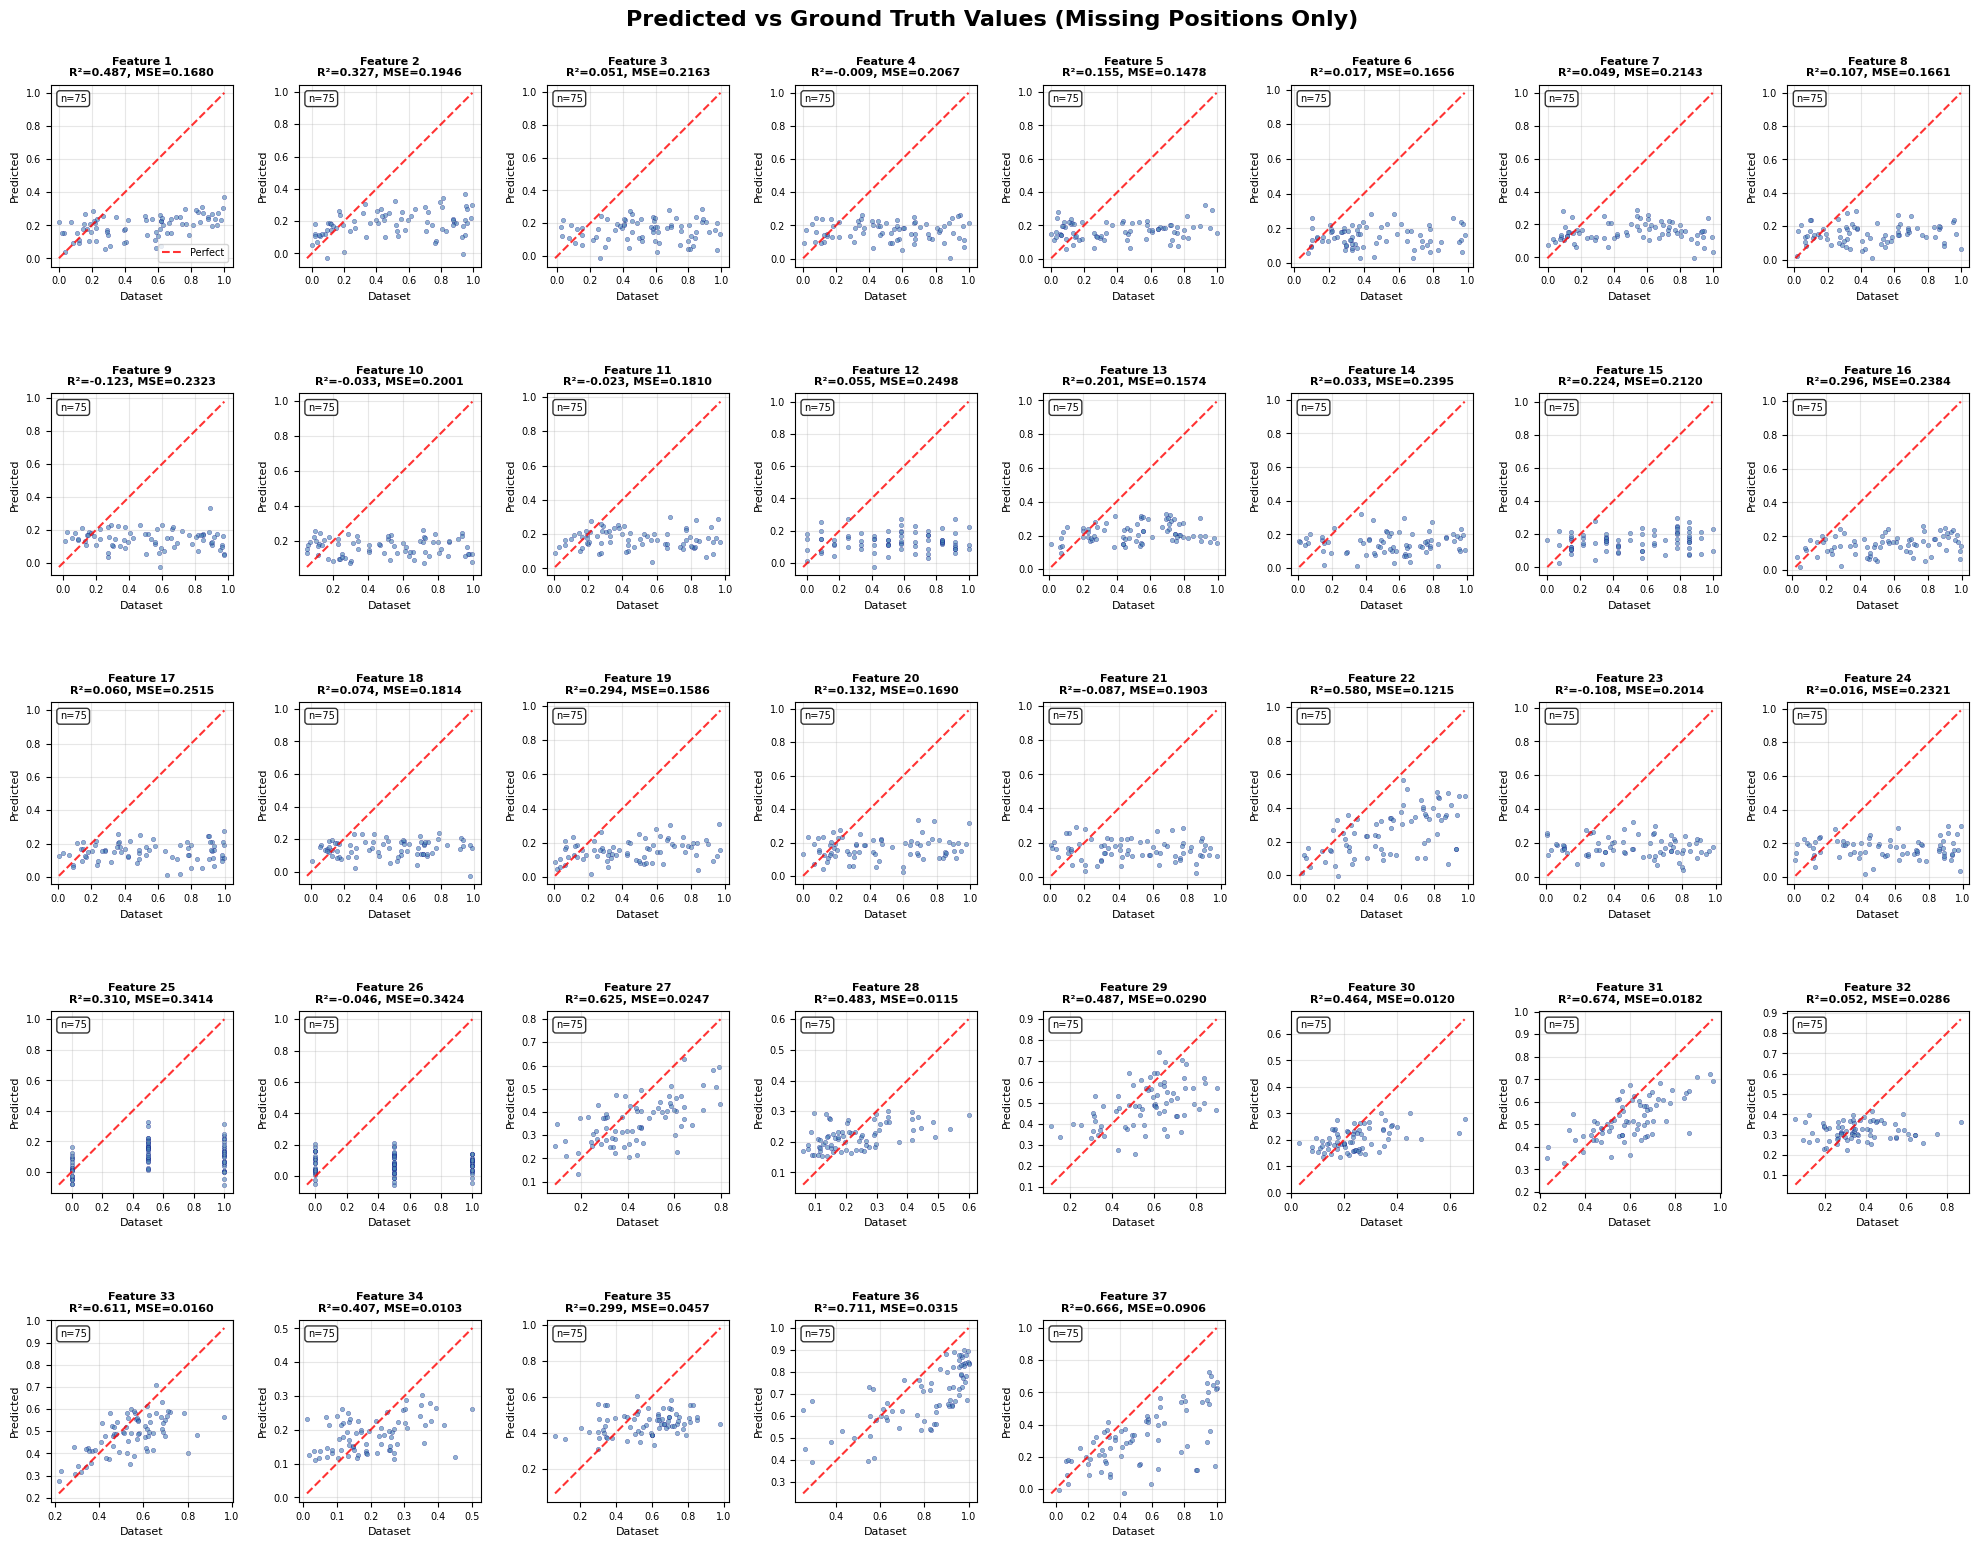

In [10]:
# Create the visualization
plot_prediction_scatter(test_imputations_denorm, test_original_denorm, test_masks, feature_names, n_features=37)



In [ ]:
def plot_distribution_comparison(test_imputations_denorm, test_original_denorm, test_masks, feature_names, n_features=25):
    """
    Create distribution comparison plots for random features in a 5x5 grid.
    
    Args:
        test_imputations_denorm: Denormalized imputed values
        test_original_denorm: Denormalized ground truth values  
        test_masks: Binary masks (1=observed, 0=missing)
        feature_names: List of feature names
        n_features: Number of features to plot (default 25 for 5x5 grid)
    """
    # Find features that have missing values
    features_with_missing = []
    for i, feature_name in enumerate(feature_names):
        missing_positions = (test_masks[:, i] == 0)  # 0 = missing in model tensors
        if missing_positions.sum() > 0:
            features_with_missing.append((i, feature_name))
    
    if len(features_with_missing) < n_features:
        n_features = len(features_with_missing)
        print(f"Only {n_features} features have missing values, showing all of them.")

    # Create 5x8 grid
    fig, axes = plt.subplots(5, 8, figsize=(20, 16))
    fig.suptitle('Distribution Comparison: Dataset vs Imputed Values', fontsize=16, fontweight='bold')
    axes = axes.flatten()

    for idx, (feature_idx, feature_name) in enumerate(features_with_missing):
        if idx >= 40:  # Safety check for 5x8 grid
            break
            
        # Get imputed and ground truth values for missing positions only
        missing_positions = (test_masks[:, feature_idx] == 0)  # 0 = missing in model tensors
        
        if missing_positions.sum() > 0:
            imputed_values = test_imputations_denorm[missing_positions, feature_idx]
            ground_truth_values = test_original_denorm[missing_positions, feature_idx]
            
            # Remove any NaN or infinite values
            valid_mask = np.isfinite(imputed_values) & np.isfinite(ground_truth_values)
            imputed_clean = imputed_values[valid_mask]
            gt_clean = ground_truth_values[valid_mask]
            
            if len(imputed_clean) > 0 and len(gt_clean) > 0:
                # Create histograms
                ax = axes[idx]
                
                # Calculate bins for both distributions
                all_values = np.concatenate([imputed_clean, gt_clean])
                bins = np.linspace(all_values.min(), all_values.max(), 20)  # Fewer bins for smaller plots
                
                # Plot histograms
                ax.hist(gt_clean, bins=bins, alpha=0.7, label='Dataset', 
                    color='skyblue', density=True, edgecolor='black', linewidth=0.3)
                ax.hist(imputed_clean, bins=bins, alpha=0.7, label='Imputed', 
                    color='lightcoral', density=True, edgecolor='black', linewidth=0.3)
                
                # Add statistical information
                gt_mean, gt_std = gt_clean.mean(), gt_clean.std()
                imp_mean, imp_std = imputed_clean.mean(), imputed_clean.std()
                correlation = np.corrcoef(gt_clean, imputed_clean)[0, 1] if len(gt_clean) > 1 else 0

                # Calculate MMD (Maximum Mean Discrepancy)
                def rbf_kernel(X, Y, gamma=1.0):
                    """RBF kernel for MMD calculation"""
                    XX = np.sum(X**2, axis=1, keepdims=True)
                    YY = np.sum(Y**2, axis=1, keepdims=True)
                    XY = np.dot(X, Y.T)
                    distances = XX + YY.T - 2*XY
                    return np.exp(-gamma * distances)
                
                def mmd_rbf(X, Y, gamma=1.0):
                    """Calculate MMD with RBF kernel"""
                    X = X.reshape(-1, 1)
                    Y = Y.reshape(-1, 1)
                    
                    m, n = len(X), len(Y)
                    
                    K_XX = rbf_kernel(X, X, gamma)
                    K_YY = rbf_kernel(Y, Y, gamma)
                    K_XY = rbf_kernel(X, Y, gamma)
                    
                    mmd = (np.sum(K_XX) / (m * m) + 
                           np.sum(K_YY) / (n * n) - 
                           2 * np.sum(K_XY) / (m * n))
                    return np.sqrt(max(mmd, 0))  # Ensure non-negative
                
                try:
                    mmd_value = mmd_rbf(gt_clean, imputed_clean)
                except:
                    mmd_value = np.nan

                # Calculate Jensen-Shannon Divergence
                try:
                    # Create histograms with same bins for JSD
                    data_range = (min(gt_clean.min(), imputed_clean.min()), 
                                 max(gt_clean.max(), imputed_clean.max()))
                    
                    if data_range[1] == data_range[0]:
                        jsd_value = 0.0  # No divergence if all values are the same
                    else:
                        bins = np.linspace(data_range[0], data_range[1], 30)
                        
                        # Get histogram probabilities
                        hist_gt, _ = np.histogram(gt_clean, bins=bins, density=True)
                        hist_imp, _ = np.histogram(imputed_clean, bins=bins, density=True)
                        
                        # Normalize to probabilities
                        hist_gt = hist_gt + 1e-10  # Add small epsilon to avoid zeros
                        hist_imp = hist_imp + 1e-10
                        hist_gt = hist_gt / hist_gt.sum()
                        hist_imp = hist_imp / hist_imp.sum()
                        
                        # Calculate Jensen-Shannon divergence
                        jsd_value = jensenshannon(hist_gt, hist_imp)
                except:
                    jsd_value = np.nan

                # Add vertical lines for means
                ax.axvline(gt_mean, color='blue', linestyle='--', alpha=0.8, linewidth=1, label='Dataset Mean' if idx == 0 else "")
                ax.axvline(imp_mean, color='red', linestyle='--', alpha=0.8, linewidth=1, label='Imputed Mean' if idx == 0 else "")
                
                # Set labels and title (smaller font for 5x5 grid)
                ax.set_xlabel(f'{feature_name[:15]}', fontsize=8)  # Truncate long names
                ax.set_ylabel('Density', fontsize=8)
                ax.tick_params(labelsize=7)
                
                # Add correlation, MMD, and JSD as title
                ax.set_title(f'R²={correlation:.3f}, MMD={mmd_value:.3f}, JSD={jsd_value:.3f}', fontsize=7, fontweight='bold')
                
                # Add legend only to first plot
                if idx == 0:
                    ax.legend(fontsize=7, loc='upper right')
                
                ax.grid(True, alpha=0.3)

            else:
                axes[idx].text(0.5, 0.5, f'{feature_name[:15]}\nNo valid data', 
                            ha='center', va='center', transform=axes[idx].transAxes, fontsize=8)
                axes[idx].set_title(f'{feature_name[:15]} - No Valid Data', fontsize=8)
        else:
            axes[idx].text(0.5, 0.5, f'{feature_name[:15]}\nNo missing values', 
                        ha='center', va='center', transform=axes[idx].transAxes, fontsize=8)
            axes[idx].set_title(f'{feature_name[:15]} - No Missing Values', fontsize=8)

    # Hide any unused subplots
    for idx in range(len(features_with_missing), 40):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

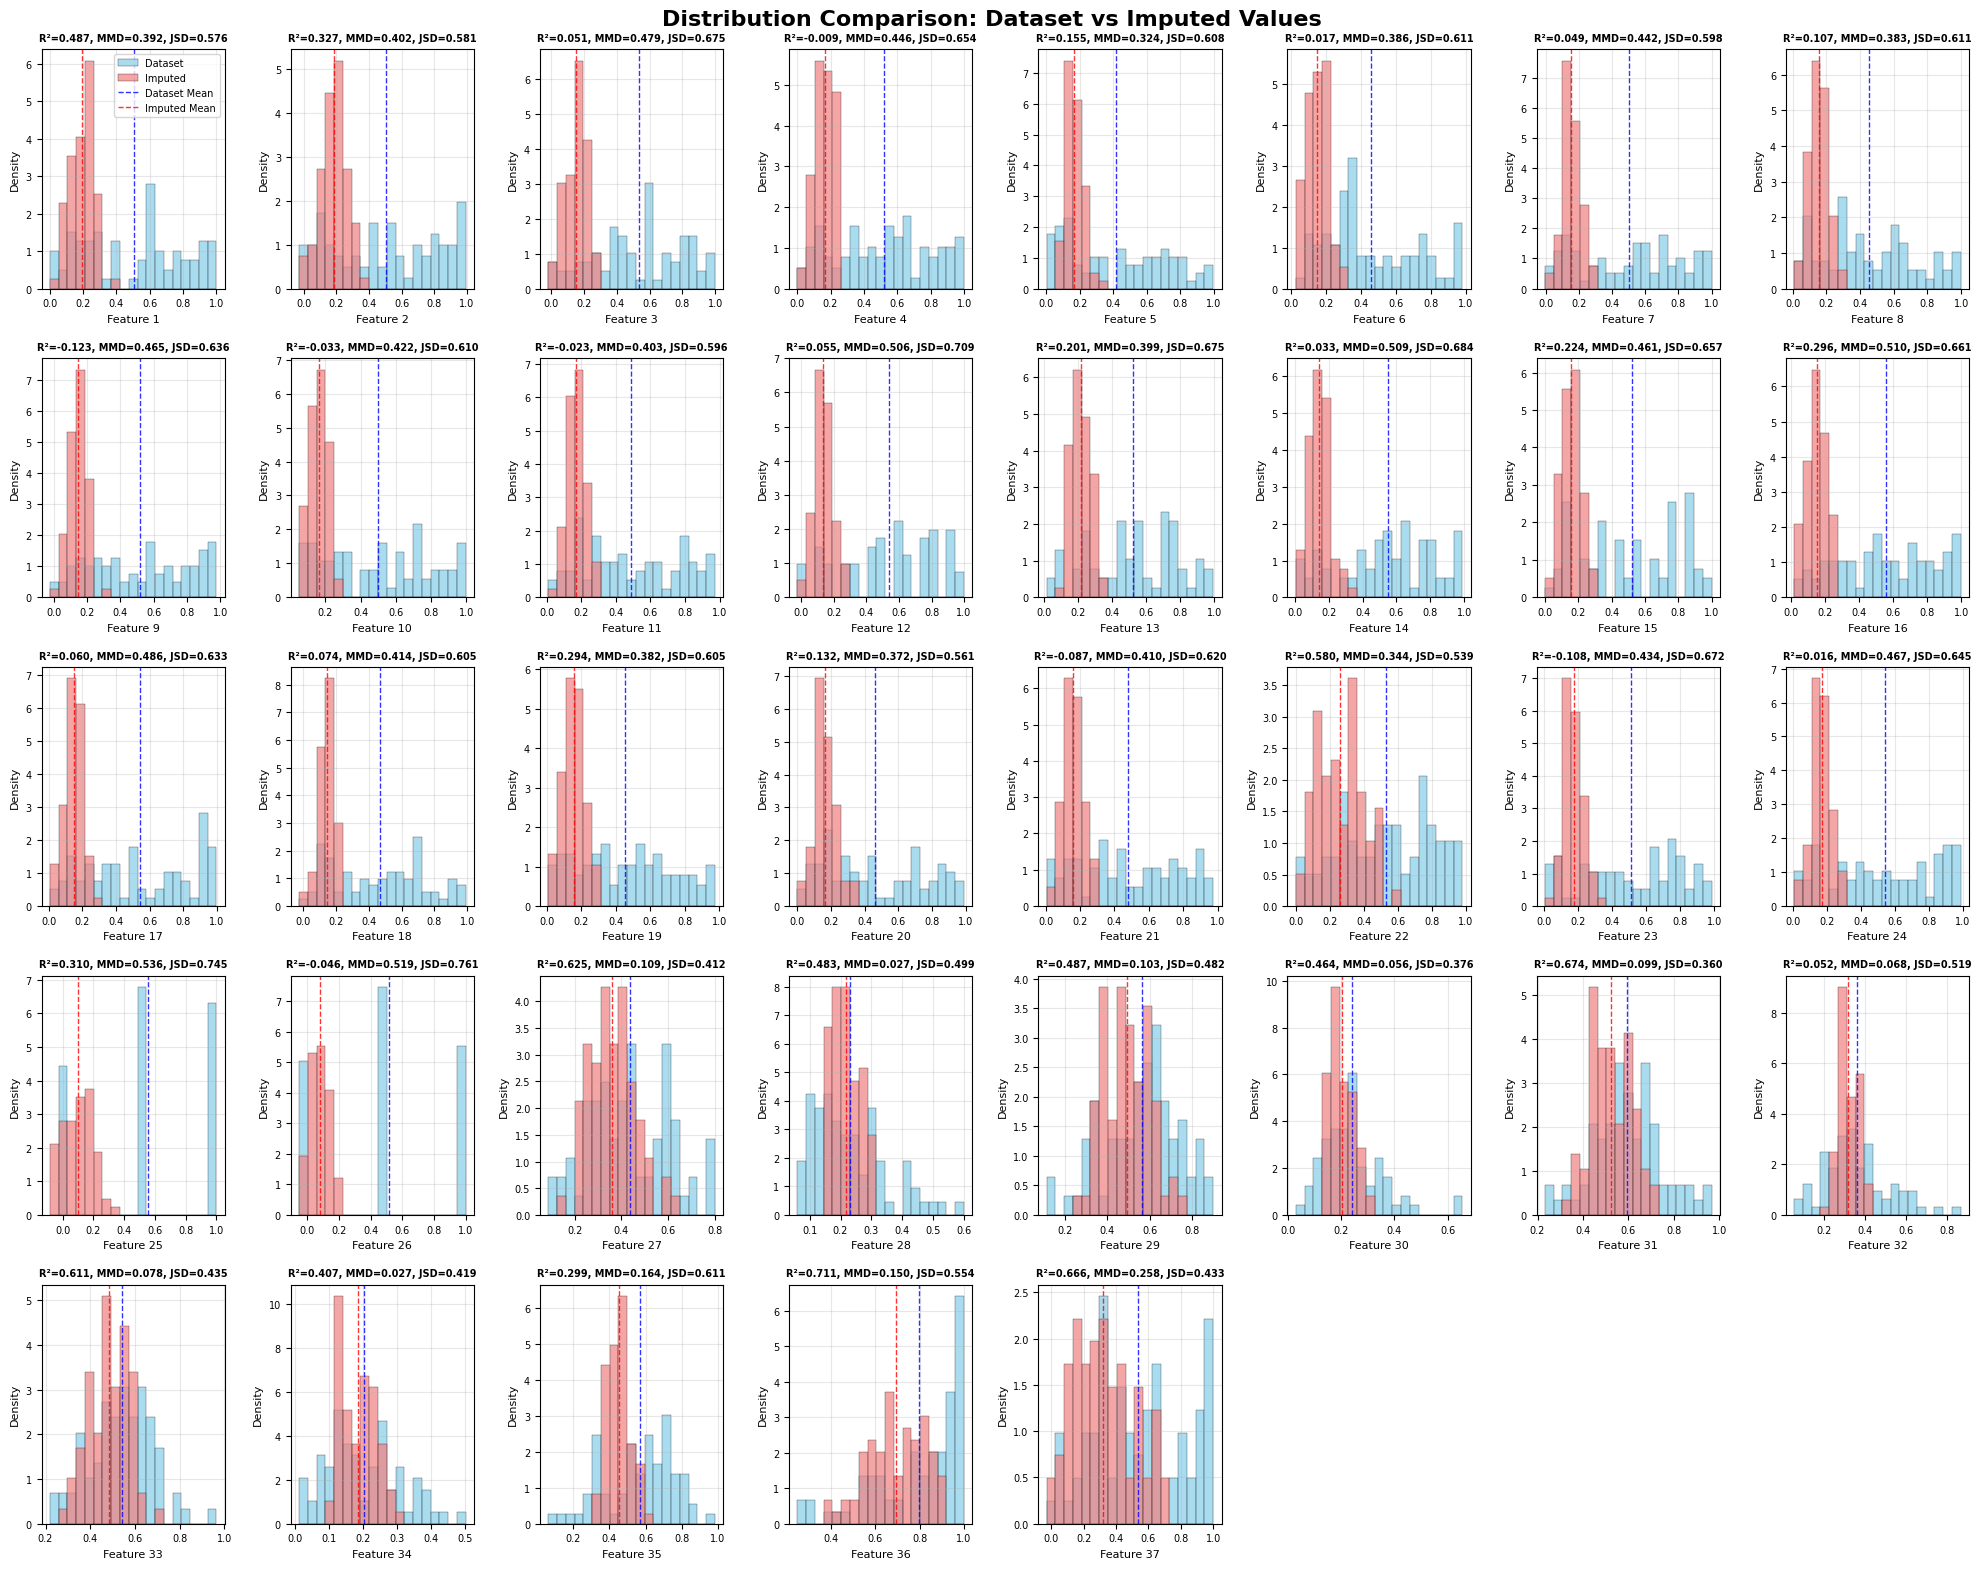

In [32]:
# Distribution comparison plots
plot_distribution_comparison(test_imputations_denorm, test_original_denorm,
                             test_masks, feature_names, n_features=25)


### Distribution Comparison Visualizations

Visual comparison of predicted vs. dataset distributions is crucial for understanding model performance beyond simple error metrics. These plots help us assess:

**What the Plots Show:**
- **Red (Imputed)**: Distribution of model's predicted values for missing positions
- **Blue (Dataset)**: Distribution of actual values at those same positions
- **Overlap**: How well the model captures the true data distribution

**Why This Matters:**
- A good generative model should not just minimize error, but also preserve the statistical properties of the data
- If distributions match well, the model is generating realistic values
- Large differences indicate the model may be systematically biased or missing important patterns

**Interpretation:**
- **Good**: Overlapping distributions with similar shapes and centers
- **Concerning**: Shifted means, different variances, or completely different shapes

In [13]:
def generate_samples(model, X_test, test_loader, device, n_samples_per_test=100):
    """Generate multiple samples for a dataset using the trained model.
    """
    # We'll generate multiple samples
    test_samples = np.zeros((X_test.shape[0], n_samples_per_test, X_test.shape[1]))

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Create a progress bar for all samples
        from tqdm import tqdm

        for batch_idx, (batch_data, batch_mask) in enumerate(tqdm(test_loader, desc="Generating Samples")):
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)

            # Calculate the indices for this batch
            start_idx = batch_idx * test_loader.batch_size
            end_idx = min(start_idx + test_loader.batch_size, X_test.shape[0])
            actual_batch_size = end_idx - start_idx

            # Generate multiple samples for each item in the batch
            for j in range(n_samples_per_test):
                # Get reconstruction
                reconstruction, mu, logvar = model(batch_data, batch_mask) # TODO: Change this line based on the model you use

                # Apply mask: keep original values where available, use reconstructed values where missing
                mask_float = batch_mask.float()
                imputed = batch_data * mask_float + reconstruction * (1 - mask_float)

                # Store the samples (already in original scale since we didn't normalize)
                test_samples[start_idx:end_idx, j, :] = imputed.cpu().numpy()
    print(f"✓ Generated samples shape: {test_samples.shape}")
    print(f"  - {test_samples.shape[0]} samples")
    print(f"  - {test_samples.shape[1]} generated variations per sample")
    print(f"  - {test_samples.shape[2]} features per sample")

    # Data is already in original scale (no denormalization needed)
    test_samples_final = test_samples.copy()

    # Calculate summary statistics
    mean_across_samples = test_samples_final.mean(axis=1)  # Mean across the 100 samples

    print(f"  - Range of means: [{mean_across_samples.min():.4f}, {mean_across_samples.max():.4f}]")

    return test_samples

In [14]:
# Test Evaluation

print("="*70)
print("TEST EVALUATION")
print("="*70)

# Generate multiple samples for test using the trained model
print(f"Generating 100 samples for each of {X_test.shape[0]} test samples...")

# test_samples = generate_samples(
#     model, X_test, test_loader, device, n_samples_per_test=100
# )
test_samples = generate_samples(
    model, X_test, test_loader, device, n_samples_per_test=100
)

TEST EVALUATION
Generating 100 samples for each of 375 test samples...


Generating Samples: 100%|██████████| 6/6 [00:01<00:00,  4.32it/s]

✓ Generated samples shape: (375, 100, 37)
  - 375 samples
  - 100 generated variations per sample
  - 37 features per sample
  - Range of means: [-0.0794, 1.0000]


In [15]:
test_score = compute_score(generated_samples=test_samples, set_name='test')
print("Test score:", test_score)

Loading data...
Found data in current directory
Test data shape: (375, 37)
Missing ratio: 20.0%
Generated samples shape: (375, 100, 37)

📊 EVALUATION RESULTS
Missing values evaluated: 2,775
MSE          : 0.1538
MAE          : 0.2977
Correlation  : 0.234
JS Divergence: 0.1866

📈 FEATURE-WISE RESULTS
Feature  MSE        MAE        Corr     JSDiv    Count   
0        0.1671     0.3340     0.495    0.3651   75      
1        0.1973     0.3521     0.319    0.3872   75      
2        0.2156     0.3964     0.055    0.4764   75      
3        0.2081     0.3751     -0.007   0.4532   75      
4        0.1478     0.3070     0.201    0.3949   75      
5        0.1673     0.3186     0.005    0.4343   75      
6        0.2149     0.3741     0.047    0.3709   75      
7        0.1662     0.3266     0.128    0.4169   75      
8        0.2307     0.3919     -0.087   0.4482   75      
9        0.2018     0.3661     -0.061   0.4230   75      
10       0.1772     0.3305     0.034    0.4011   75      
11 

The final score is computed as: Mean Correlation − Mean JS Divergence − Mean MSE

Just as we compare generated samples for the test set against the original unimputed values, we will apply the same metric to the samples you generate for test2, using the hidden test2 set. This will determine your final submission score.

## Preparing a submission:
Let's prepare a submission. We expect the final submission to be a 417x100x37 numpy array. These correspond to the 100 diverse samples you generated based on the constrained parameters we provided in the test2 set.

In [16]:
# Test2 Evaluation

print("="*70)
print("TEST2 EVALUATION")
print("="*70)

# Generate multiple samples for test2 using the trained model
print(f"Generating 100 samples for each of {X_test2.shape[0]} test2 samples...")

test2_samples = generate_samples(
    model, X_test2, test2_loader, device, n_samples_per_test=100
)

TEST2 EVALUATION
Generating 100 samples for each of 417 test2 samples...


Generating Samples: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

✓ Generated samples shape: (417, 100, 37)
  - 417 samples
  - 100 generated variations per sample
  - 37 features per sample
  - Range of means: [-0.1108, 1.0000]


### Test2 Evaluation: Generating Diverse Design Completions

This is the core evaluation for your AI Copilot assignment. Here we:

**Input**: Test2 samples with some known features (constraints) and some missing features (free parameters)

**Output**: 100 diverse, plausible completions for each test sample

**Why 100 Samples?**
- Engineers want to explore multiple design options, not just one "best" solution
- Diversity helps discover unexpected but valid design combinations  

**Technical Process:**
1. For each test2 sample, use the trained model to generate 100 different completions
2. Each completion respects the known constraints (observed values)
3. Missing values are filled with diverse, model-generated predictions
4. Final output: 417 × 100 × 37 array (417 test samples, 100 variants each, 37 features)

In [17]:
id = np.random.randint(1e8, 1e9-1)
np.save(f"{id}.npy", test2_samples)

### Summary and Tips for CP3

The VAE baseline reproduces the dataset distribution well for some features, but others still show substantial discrepancies, indicating significant room for improvement!

**Key Observations:**
- **Strengths**: The model captures general feature ranges and some distributional patterns
- **Weaknesses**: Some features show systematic bias or poor distribution matching
- **Opportunities**: Advanced architectures (diffusion models, transformers) or better conditioning strategies could improve performance

**For Your Assignment**: Consider these results as a baseline. Think about:
- Which features are hardest to predict and why?
- How could you modify the architecture or training process?
- What additional constraints or domain knowledge could help?

# Fist try with a diffusion model


In [18]:
# Diffusion-based tabular imputer (DDPM-style)
# This cell implements a lightweight denoising diffusion probabilistic model (DDPM)
# tailored for tabular imputation (conditioned on observed values via the mask).
# It's self-contained and does not require external 'diffusers' packages.

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import tqdm

# -- Utilities: noise schedule and timestep embedding --
def make_beta_schedule(T, start=1e-4, end=0.02, device='cpu'):
    return torch.linspace(start, end, T, device=device)

def sinusoidal_timestep_embedding(timesteps, dim):
    half = dim // 2
    emb = math.log(10000) / (half - 1)
    emb = torch.exp(torch.arange(half, device=timesteps.device) * -emb)
    emb = timesteps[:, None].float() * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if dim % 2 == 1:
        emb = F.pad(emb, (0,1))
    return emb

# -- Simple MLP denoiser with timestep & mask conditioning --
class MLPDenoiser(nn.Module):
    def __init__(self, input_dim, hidden=512, timesteps_embed_dim=128):
        super().__init__()
        self.input_dim = input_dim
        self.hidden = hidden
        self.timesteps_embed_dim = timesteps_embed_dim

        # Time embedding MLP -> produces a vector of size `hidden`
        self.time_mlp = nn.Sequential(
            nn.Linear(timesteps_embed_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
        )

        # Project time embedding to match final output dimension so it can be added to network output
        self.time_to_output = nn.Linear(hidden, input_dim)

        # The network input will be: noisy_x (input_dim) + observed_values (input_dim) + mask (input_dim)
        in_dim = input_dim * 3
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, input_dim)
        )

    def forward(self, noisy_x, cond_x, mask, t):
        # t: tensor of shape (B,) with timestep indices
        # Create sinusoidal embedding of timesteps with the requested embedding dim
        t_emb = sinusoidal_timestep_embedding(t, self.timesteps_embed_dim)
        t_emb = self.time_mlp(t_emb)  # (B, hidden)

        # Project time embedding to output dimension so it can be added to net output
        t_out = self.time_to_output(t_emb)  # (B, input_dim)

        # Concatenate noisy input, conditional observed values and mask
        inp = torch.cat([noisy_x, cond_x * mask, mask], dim=1)  # (B, in_dim)
        net_out = self.net(inp)  # (B, input_dim)

        # Add projected time features (elementwise) to network output
        h = net_out + t_out
        return h

# -- DDPM helper functions --
class DiffusionImputer:
    def __init__(self, input_dim, T=1000, device='cpu'):
        self.device = device
        self.input_dim = input_dim
        self.T = T
        self.model = MLPDenoiser(input_dim).to(device)
        self.beta = make_beta_schedule(T, device=device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.optimizer = optim.Adam(self.model.parameters(), lr=2e-4)

    def q_sample(self, x_start, t, noise=None):
        # x_start: (B, D) clean data; t: (B,) timesteps
        if noise is None:
            noise = torch.randn_like(x_start)
        a_bar = self.alpha_bar[t].unsqueeze(1)
        return torch.sqrt(a_bar) * x_start + torch.sqrt(1 - a_bar) * noise, noise

    def p_losses(self, x_start, cond_x, mask, t):
        x_noisy, noise = self.q_sample(x_start, t)
        pred_noise = self.model(x_noisy, cond_x, mask, t)
        loss = F.mse_loss(pred_noise * (1 - mask), noise * (1 - mask))
        # We only compute loss on missing positions (1-mask) so model learns to predict missing values' noise
        return loss

    @torch.no_grad()
    def sample(self, cond_x, mask, n_steps=None):
        # cond_x: observed values (B,D), mask: (B,D) with 1=observed, 0=missing
        n_steps = self.T if n_steps is None else n_steps
        bsz = cond_x.size(0)
        x = torch.randn(bsz, self.input_dim, device=self.device)

        for i in reversed(range(n_steps)):
            t = torch.full((bsz,), i, dtype=torch.long, device=self.device)
            pred_noise = self.model(x, cond_x, mask, t)
            beta_t = self.beta[i]
            alpha_t = self.alpha[i]
            alpha_bar_t = self.alpha_bar[i]

            # Predict x0 from x_t and predicted noise
            x0_pred = (x - torch.sqrt(1 - alpha_bar_t) * pred_noise) / torch.sqrt(alpha_bar_t)

            coef1 = beta_t / torch.sqrt(1 - alpha_bar_t)
            mean = torch.sqrt(1.0 / alpha_t) * (x - coef1 * pred_noise)

            if i > 0:
                noise = torch.randn_like(x)
                sigma = torch.sqrt(beta_t)
                x = mean + sigma * noise
            else:
                x = mean

            # Re-impose observed values so conditioning always holds exactly
            x = cond_x * mask + x * (1 - mask)

        return x.cpu().numpy()

# -- Training helpers (simple epoch loop) --
def train_diffusion(imputer, train_loader, val_loader=None, epochs=20, device='cpu', ckpt_path='diffusion_imputer.pth'):
    imputer.model.train()
    for epoch in range(epochs):
        pbar = tqdm.tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        epoch_loss = 0.0
        for batch_x, batch_mask in pbar:
            batch_x = batch_x.to(device)
            batch_mask = batch_mask.to(device)

            # Random timesteps for each sample
            t = torch.randint(0, imputer.T, (batch_x.size(0),), device=device, dtype=torch.long)
            loss = imputer.p_losses(batch_x, batch_x, batch_mask, t)

            imputer.optimizer.zero_grad()
            loss.backward()
            imputer.optimizer.step()

            epoch_loss += loss.item() * batch_x.size(0)
            pbar.set_postfix({'loss': f'{loss.item():.6f}'})

        avg_loss = epoch_loss / (len(train_loader.dataset))
        # print(f'Epoch {epoch+1}/{epochs} - Avg Loss: {avg_loss:.6f}')
        torch.save(imputer.model.state_dict(), ckpt_path)

    print('✓ Diffusion training complete')

# -- Usage example (copy into a cell and run to train) --
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# imputer = DiffusionImputer(input_dim=config['input_dim'], T=200, device=device)
# train_diffusion(imputer, train_loader, val_loader=val_loader, epochs=10, device=device)
# # Generate imputations: returns numpy array (B, D)
# sample = imputer.sample(cond_x=batch_data.to(device), mask=batch_mask.to(device), n_steps=200)

# Notes:
# - This implementation is a compact DDPM variant for tabular data. It conditions on observed values by concatenation
#   and re-imposes the observed features during sampling to guarantee constraints.
# - The model trains only on missing positions (loss masked) so it focuses on reconstructing omitted values.
# - You can tune T (timesteps), model hidden size, and training schedule. Use smaller T (e.g., 200) for fast experiments.
# - If you want the Hugging Face `diffusers` pipelines instead, I can add instructions to install it and adapt a tabular
#   pipeline using their Unet/ModelMlp components, but that will add dependencies.


In [19]:
# Train diffusion imputer (short run) and compare to the VAE baseline
print('\n' + '='*70)
print('DIFFUSION TRAIN & COMPARE')
print('='*70)

# Device (should already be defined earlier, but keep fallback)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the imputer (use smaller T for quicker experiments)
imputer = DiffusionImputer(input_dim=config['input_dim'], T=1000, device=device)

# Quick training run - adjust epochs as needed (start small for a smoke test)
quick_epochs = 100
train_diffusion(imputer, train_loader, val_loader=val_loader, epochs=quick_epochs, device=device, ckpt_path='diffusion_imputer.pth')

# Evaluation helper for diffusion imputer (generates multiple samples per input)
def evaluate_diffusion_imputer(imputer, data_loader, device, n_samples=20, n_steps=200):
    imputer.model.eval()
    all_imputations = []  # will hold (B, n_samples, D) blocks
    all_originals = []
    all_masks = []

    with torch.no_grad():
        for batch_data, batch_mask in data_loader:
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)

            samples = []
            for _ in range(n_samples):
                out = imputer.sample(batch_data, batch_mask, n_steps=n_steps)  # numpy (B, D)
                samples.append(out)

            samples = np.stack(samples, axis=1)  # (B, n_samples, D)
            all_imputations.append(samples)
            all_originals.append(batch_data.cpu().numpy())
            # keep numeric mask (1=observed,0=missing) so callers can compute missing positions via (mask==0)
            all_masks.append(batch_mask.cpu().numpy())

    imputations = np.concatenate(all_imputations, axis=0)
    originals = np.vstack(all_originals)
    masks = np.vstack(all_masks)
    return imputations, originals, masks

# Run evaluation on the test set (this may take time depending on n_samples)
print('Evaluating diffusion imputer on test set...')
diff_imputations, diff_originals, diff_masks = evaluate_diffusion_imputer(imputer, test_loader, device, n_samples=20, n_steps=200)
print('✓ Diffusion imputations generated')

# Summarize metrics similar to VAE evaluation (use mean across samples)
diff_mean_imputed = diff_imputations.mean(axis=1)  # (N, D)
# missing_mask: True where values were missing (mask==0 in model tensors)
missing_mask = (diff_masks == 0)
feature_metrics_diff = {}
for i, fname in enumerate(feature_names):
    if missing_mask[:, i].sum() > 0:
        imputed_missing = diff_mean_imputed[missing_mask[:, i], i]
        ground_truth_missing = diff_originals[missing_mask[:, i], i]

        mse = mean_squared_error(ground_truth_missing, imputed_missing)
        mae = mean_absolute_error(ground_truth_missing, imputed_missing)
        try:
            corr = np.corrcoef(ground_truth_missing, imputed_missing)[0,1]
        except:
            corr = np.nan
        mean_diff, js_div = calculate_jsd_and_mean_diff(imputed_missing, ground_truth_missing, fname)

        feature_metrics_diff[fname] = {'n_missing': missing_mask[:, i].sum(), 'mse': mse, 'mae': mae, 'correlation': corr, 'mean_difference': mean_diff, 'js_divergence': js_div}

print(f'\n✓ Diffusion metrics calculated for {len(feature_metrics_diff)} features with missing values')

# Print summary statistics (same as earlier VAE cell)
all_mse = [m['mse'] for m in feature_metrics_diff.values() if not np.isnan(m['mse'])]
all_mae = [m['mae'] for m in feature_metrics_diff.values() if not np.isnan(m['mae'])]
all_corr = [m['correlation'] for m in feature_metrics_diff.values() if not np.isnan(m['correlation'])]
all_mean_diff = [m['mean_difference'] for m in feature_metrics_diff.values() if not np.isnan(m['mean_difference'])]
all_js_div = [m['js_divergence'] for m in feature_metrics_diff.values() if not np.isnan(m['js_divergence'])]

print('\nDiffusion Summary Statistics Across All Features:')
print(f'  - Average MSE: {np.mean(all_mse):.4f} ± {np.std(all_mse):.4f}')
print(f'  - Average MAE: {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}')
print(f'  - Average Correlation: {np.mean(all_corr):.3f} ± {np.std(all_corr):.3f}')
print(f'  - Average Mean Difference: {np.mean(all_mean_diff):.4f} ± {np.std(all_mean_diff):.4f}')
print(f'  - Average JS Divergence: {np.mean(all_js_div):.4f} ± {np.std(all_js_div):.4f}')

# If VAE test imputations exist in the notebook namespace, compute the same score and compare
if 'test_imputations' in globals():
    print('\nComparing to VAE results (if available)')
    # VAE's test_imputations may have shape (N, D) or (N, n_samples, D) depending on how generated; handle both
    vae_samples = test_imputations
    if vae_samples.ndim == 3:
        vae_mean = vae_samples.mean(axis=1)
    else:
        vae_mean = vae_samples

    # Compute a simple average MSE over missing positions for VAE mean vs diffusion mean
    # Use the same missing positions mask computed above
    vae_errors = ((vae_mean - X_test_original) ** 2)[missing_mask]
    diff_errors = ((diff_mean_imputed - diff_originals) ** 2)[missing_mask]
    print(f'  - VAE mean MSE on missing positions: {vae_errors.mean():.6f}')
    print(f'  - Diffusion mean MSE on missing positions: {diff_errors.mean():.6f}')
else:
    print('VAE test imputations variable `test_imputations` not found in the notebook namespace. Run the VAE evaluation cell first to compare.')

# Optionally compute the same final metric used for the challenge if compute_score is available
if 'compute_score' in globals():
    try:
        print('\nComputing challenge-style score for diffusion samples (may take time)')
        diff_score = compute_score(generated_samples=diff_imputations, set_name='test')
        print('Diffusion score:', diff_score)
    except Exception as e:
        print('compute_score failed:', e)

print('\n✓ Diffusion training + comparison cell complete. Review outputs above.')



DIFFUSION TRAIN & COMPARE


Epoch 100/100: 100%|██████████| 47/47 [00:00<00:00, 181.04it/s, loss=0.021106]


✓ Diffusion training complete
Evaluating diffusion imputer on test set...
✓ Diffusion imputations generated

✓ Diffusion metrics calculated for 37 features with missing values

Diffusion Summary Statistics Across All Features:
  - Average MSE: 0.0786 ± 0.0358
  - Average MAE: 0.2262 ± 0.0647
  - Average Correlation: 0.218 ± 0.235
  - Average Mean Difference: 0.0904 ± 0.0515
  - Average JS Divergence: 0.5807 ± 0.0907

Comparing to VAE results (if available)
  - VAE mean MSE on missing positions: 0.153984
  - Diffusion mean MSE on missing positions: 0.078645

Computing challenge-style score for diffusion samples (may take time)
Loading data...
Found data in current directory
Test data shape: (375, 37)
Missing ratio: 20.0%
Generated samples shape: (375, 20, 37)

📊 EVALUATION RESULTS
Missing values evaluated: 2,775
MSE          : 0.0786
MAE          : 0.2262
Correlation  : 0.334
JS Divergence: 0.1570

📈 FEATURE-WISE RESULTS
Feature  MSE        MAE        Corr     JSDiv    Count   
0       

In [20]:
# Generate multiple samples from the trained diffusion imputer (N x S x D)
def generate_samples_diffusion(imputer, X_test, test_loader, device, n_samples_per_test=100, n_steps=200):
    """Generate multiple imputations per test sample using the diffusion imputer.

    Returns:
        test_samples: numpy array shape (N, n_samples_per_test, D)
    """
    imputer.model.eval()

    N = X_test.shape[0]
    D = X_test.shape[1]
    test_samples = np.zeros((N, n_samples_per_test, D))

    with torch.no_grad():
        for batch_idx, (batch_data, batch_mask) in enumerate(tqdm.tqdm(test_loader, desc='Generating Diffusion Samples')):
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)

            start_idx = batch_idx * test_loader.batch_size
            end_idx = min(start_idx + test_loader.batch_size, N)
            actual_batch_size = end_idx - start_idx

            # Generate n_samples_per_test samples for this batch
            for j in range(n_samples_per_test):
                out = imputer.sample(batch_data, batch_mask, n_steps=n_steps)  # numpy (B, D)
                # If imputer.sample returns a larger batch (shouldn't), trim to actual_batch_size
                out = np.asarray(out)
                if out.shape[0] != actual_batch_size:
                    out = out[:actual_batch_size]
                test_samples[start_idx:end_idx, j, :] = out

    print(f"✓ Generated samples shape: {test_samples.shape}")
    return test_samples

In [21]:

test2_samples = generate_samples_diffusion(imputer, X_test2, test2_loader, device, n_samples_per_test=100)
id = np.random.randint(1e8, 1e9-1)
np.save(f"{id}.npy", test2_samples)
print(f"Saved diffusion test2 samples to {id}.npy")

Generating Diffusion Samples: 100%|██████████| 7/7 [01:21<00:00, 11.71s/it]

✓ Generated samples shape: (417, 100, 37)
Saved diffusion test2 samples to 832395540.npy


In [22]:
# Improved VAE: deeper gated residual blocks, LayerNorm, FiLM conditioning, and heteroscedastic continuous head
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class MLPBlock(nn.Module):
    def __init__(self, dim_in, dim_out, dropout=0.1, use_residual=False):
        super().__init__()
        self.fc = nn.Linear(dim_in, dim_out)
        self.norm = nn.LayerNorm(dim_out)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.use_residual = use_residual and (dim_in == dim_out)

    def forward(self, x):
        h = self.fc(x)
        h = self.norm(h)
        h = self.act(h)
        h = self.dropout(h)
        if self.use_residual:
            return x + h
        return h

class VAE(nn.Module):
    """
    Improved VAE for mixed continuous + categorical tabular imputation.
    - LayerNorm + GELU MLP blocks (stable for small batches)
    - FiLM-style conditioning in decoder: latent -> (gamma,beta) per decoder layer
    - Continuous head predicts mean and log-variance per feature (heteroscedastic)
    - Categorical heads return logits per categorical feature
    - Impute method samples continuous/categorical outputs appropriately
    """
    def __init__(
        self,
        input_dim,
        latent_dim=128,
        hidden_dims=[512, 256, 128],
        dropout=0.1,
        dropout_rate=None,
        cat_feature_idxs=None,
        cat_dims=None,
        cat_embed_dim=8,
        use_residual=True,
    ):
        super().__init__()
        # backward-compatibility: if caller provided dropout_rate, use it
        if dropout_rate is not None:
            dropout = dropout_rate

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims
        self.use_residual = use_residual

        # default categorical features (0-based indices)
        self.cat_feature_idxs = cat_feature_idxs if cat_feature_idxs is not None else [24, 25]
        self.cat_dims = cat_dims if cat_dims is not None else {24: 3, 25: 3}
        self.cat_embed_dim = cat_embed_dim

        # embeddings
        self.cat_embeds = nn.ModuleDict({
            str(i): nn.Embedding(self.cat_dims[i], cat_embed_dim) for i in self.cat_feature_idxs
        })
        total_cat_embed_dim = cat_embed_dim * len(self.cat_feature_idxs)

        # feature importance network (small)
        self.feature_importance = nn.Sequential(
            nn.Linear(input_dim * 2, max(hidden_dims[0] // 4, 32)),
            nn.ReLU(),
            nn.Linear(max(hidden_dims[0] // 4, 32), input_dim),
            nn.Sigmoid(),
        )

        # Encoder MLP stack
        enc_in_dim = input_dim * 2 + total_cat_embed_dim
        enc_dims = [enc_in_dim] + hidden_dims
        self.encoder_blocks = nn.ModuleList()
        for i in range(len(enc_dims) - 1):
            self.encoder_blocks.append(MLPBlock(enc_dims[i], enc_dims[i + 1], dropout=dropout, use_residual=self.use_residual))

        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)
        nn.init.xavier_uniform_(self.fc_mu.weight, gain=0.05)
        nn.init.xavier_uniform_(self.fc_logvar.weight, gain=0.05)
        nn.init.constant_(self.fc_logvar.bias, -3.0)

        # Decoder: latent + observed + positional + cat_emb
        dec_in_dim = latent_dim + input_dim + input_dim + total_cat_embed_dim
        dec_dims = [dec_in_dim] + list(reversed(hidden_dims))
        self.decoder_blocks = nn.ModuleList()
        for i in range(len(dec_dims) - 1):
            self.decoder_blocks.append(MLPBlock(dec_dims[i], dec_dims[i + 1], dropout=dropout, use_residual=self.use_residual))

        # FiLM generators (one per decoder layer) to produce gamma/beta from latent
        self.film_generators = nn.ModuleList()
        for hdim in dec_dims[1:]:
            self.film_generators.append(nn.Linear(latent_dim, hdim * 2))

        # Continuous heads: mean and logvar per feature
        self.cont_mu = nn.Linear(dec_dims[-1], input_dim)
        self.cont_logvar = nn.Linear(dec_dims[-1], input_dim)
        nn.init.xavier_uniform_(self.cont_mu.weight, gain=0.05)
        nn.init.xavier_uniform_(self.cont_logvar.weight, gain=0.05)

        # Categorical heads
        self.cat_heads = nn.ModuleDict({
            str(i): nn.Linear(dec_dims[-1], self.cat_dims[i]) for i in self.cat_feature_idxs
        })

    def _build_cat_emb(self, x, mask):
        mask_f = mask.float()
        emb_list = []
        for idx in self.cat_feature_idxs:
            raw = x[:, idx]
            # map to classes robustly (nearest to 0.0,0.5,1.0)
            cls = torch.zeros_like(raw, dtype=torch.long)
            cls = torch.where((raw - 0.5).abs() < (raw - 0.0).abs(), torch.ones_like(cls), cls)
            cls = torch.where((raw - 1.0).abs() < (raw - 0.5).abs(), torch.full_like(cls, 2), cls)
            emb = self.cat_embeds[str(idx)](cls)
            emb = emb * mask_f[:, idx:idx + 1]
            emb_list.append(emb)
        if emb_list:
            return torch.cat(emb_list, dim=1)
        return torch.zeros(x.size(0), 0, device=x.device)

    def encode(self, x, mask):
        mask_f = mask.float()
        cat_emb = self._build_cat_emb(x, mask)

        importance_in = torch.cat([x * mask_f, mask_f], dim=1)
        importance = self.feature_importance(importance_in)
        weighted = x * mask_f * importance

        enc_in = torch.cat([weighted, mask_f, cat_emb], dim=1)
        h = enc_in
        for block in self.encoder_blocks:
            h = block(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h).clamp(min=-10.0, max=10.0)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, x_observed, mask):
        mask_f = mask.float()
        x_masked = x_observed * mask_f
        pos = torch.arange(self.input_dim, device=z.device, dtype=torch.float32).unsqueeze(0) / float(self.input_dim)
        pos = pos.expand(z.size(0), -1)
        cat_emb = self._build_cat_emb(x_observed, mask)

        dec_in = torch.cat([z, x_masked, pos, cat_emb], dim=1)
        h = dec_in
        # apply decoder blocks with FiLM
        for i, block in enumerate(self.decoder_blocks):
            h = block(h)
            # FiLM
            film = self.film_generators[i](z)
            gamma, beta = film.chunk(2, dim=1)
            h = h * (1.0 + gamma) + beta

        mu = self.cont_mu(h)
        logvar = self.cont_logvar(h).clamp(min=-10.0, max=5.0)

        cat_logits = {int(k): v(h) for k, v in self.cat_heads.items()}
        return mu, logvar, cat_logits

    def forward(self, x, mask):
        mu, logvar = self.encode(x, mask)
        z = self.reparameterize(mu, logvar)
        recon_mu, recon_logvar, recon_cat_logits = self.decode(z, x, mask)
        return recon_mu, recon_logvar, recon_cat_logits, mu, logvar

    def impute(self, x_incomplete, mask, n_samples=10):
        self.eval()
        samples = []
        with torch.no_grad():
            mu, logvar = self.encode(x_incomplete, mask)
            for _ in range(n_samples):
                z = self.reparameterize(mu, logvar)
                cont_mu, cont_logvar, cat_logits = self.decode(z, x_incomplete, mask)
                cont_std = torch.exp(0.5 * cont_logvar)
                # sample continuous
                eps = torch.randn_like(cont_mu)
                cont_sample = cont_mu + eps * cont_std
                imputed = x_incomplete * mask.float() + cont_sample * (1 - mask.float())
                # categorical: sample from softmax
                for idx in self.cat_feature_idxs:
                    logits = cat_logits[idx]
                    probs = F.softmax(logits, dim=1)
                    sampled = torch.multinomial(probs, num_samples=1).squeeze(1).cpu().numpy()
                    mapped = np.array([0.0, 0.5, 1.0])[sampled]
                    imputed_np = imputed.cpu().numpy()
                    miss = (mask[:, idx] == 0).cpu().numpy()
                    imputed_np[miss, idx] = mapped[miss]
                    imputed = torch.from_numpy(imputed_np).to(x_incomplete.device)
                samples.append(imputed.cpu().numpy())
        return np.stack(samples, axis=1)

print('Replaced VAE with improved architecture (LayerNorm + FiLM + heteroscedastic heads).')


Replaced VAE with improved architecture (LayerNorm + FiLM + heteroscedastic heads).


In [23]:
# Smoke test for improved mixed-output VAE (one-batch forward + mixed loss)
import torch
import numpy as np
import torch.nn.functional as F
import math

device = torch.device('cpu')
input_dim = 37
batch_size = 8

# Build synthetic batch: continuous random values + categorical positions set to {0.0,0.5,1.0}
X = torch.randn(batch_size, input_dim, device=device)
vals = np.array([0.0, 0.5, 1.0])
for i in range(batch_size):
    X[i, 24] = float(np.random.choice(vals))
    X[i, 25] = float(np.random.choice(vals))

# Random observation mask (1=observed, 0=missing)
mask = (torch.rand(batch_size, input_dim, device=device) < 0.8).long()

model = VAE(input_dim=input_dim).to(device)
model.train()

# The improved VAE.forward returns (cont_mu, cont_logvar, cat_logits, mu, logvar)
recon_mu, recon_logvar, recon_cat_logits, mu, logvar = model(X, mask)
print('recon_mu shape', recon_mu.shape)
print('categorical logits keys', list(recon_cat_logits.keys()))

mask_f = mask.float()
# Heteroscedastic Gaussian negative log-likelihood for observed entries
var = torch.exp(recon_logvar)
nll_elem = 0.5 * (((X - recon_mu) ** 2) / var + recon_logvar + math.log(2 * math.pi))
obs_count = mask_f.sum().clamp(min=1.0)
cont_loss = (nll_elem * mask_f).sum() / obs_count

cat_loss = torch.tensor(0.0, device=device)
for idx in model.cat_feature_idxs:
    raw = X[:, idx]
    targets = torch.zeros_like(raw, dtype=torch.long)
    targets = torch.where((raw - 0.5).abs() < (raw - 0.0).abs(), torch.ones_like(targets), targets)
    targets = torch.where((raw - 1.0).abs() < (raw - 0.5).abs(), torch.full_like(targets, 2), targets)
    logits = recon_cat_logits[idx]
    obs = (mask[:, idx] == 1)
    if obs.sum() > 0:
        cat_loss = cat_loss + F.cross_entropy(logits[obs], targets[obs])

kl = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
loss = cont_loss + cat_loss + 0.1 * kl

print(f'cont_loss={cont_loss.item():.6f} cat_loss={cat_loss.item():.6f} kl={kl.item():.6f} total_loss={loss.item():.6f}')


recon_mu shape torch.Size([8, 37])
categorical logits keys [24, 25]
cont_loss=1.461679 cat_loss=2.402452 kl=131.380844 total_loss=17.002214


Loading: c:\sources\2155-CP3\dataset\train_original.csv
Raw data shape: (2998, 37) -> feature matrix shape: (2998, 37)
Covariance matrix shape: (37, 37)

Top 15 absolute correlation pairs:
Feature 30 <-> Feature 34: 0.918325
Feature 22 <-> Feature 37: 0.865474
Feature 36 <-> Feature 37: -0.820527
Feature 1 <-> Feature 31: 0.781758
Feature 22 <-> Feature 36: -0.765075
Feature 29 <-> Feature 33: 0.760900
Feature 29 <-> Feature 31: 0.595475
Feature 28 <-> Feature 34: 0.498570
Feature 25 <-> Feature 27: -0.480233
Feature 25 <-> Feature 29: 0.467380
Feature 28 <-> Feature 30: 0.451511
Feature 27 <-> Feature 29: -0.440942
Feature 2 <-> Feature 34: 0.431931
Feature 19 <-> Feature 27: 0.413815
Feature 2 <-> Feature 30: 0.379667

Saved covariance matrix to c:\sources\2155-CP3\outputs\train_covariance.csv


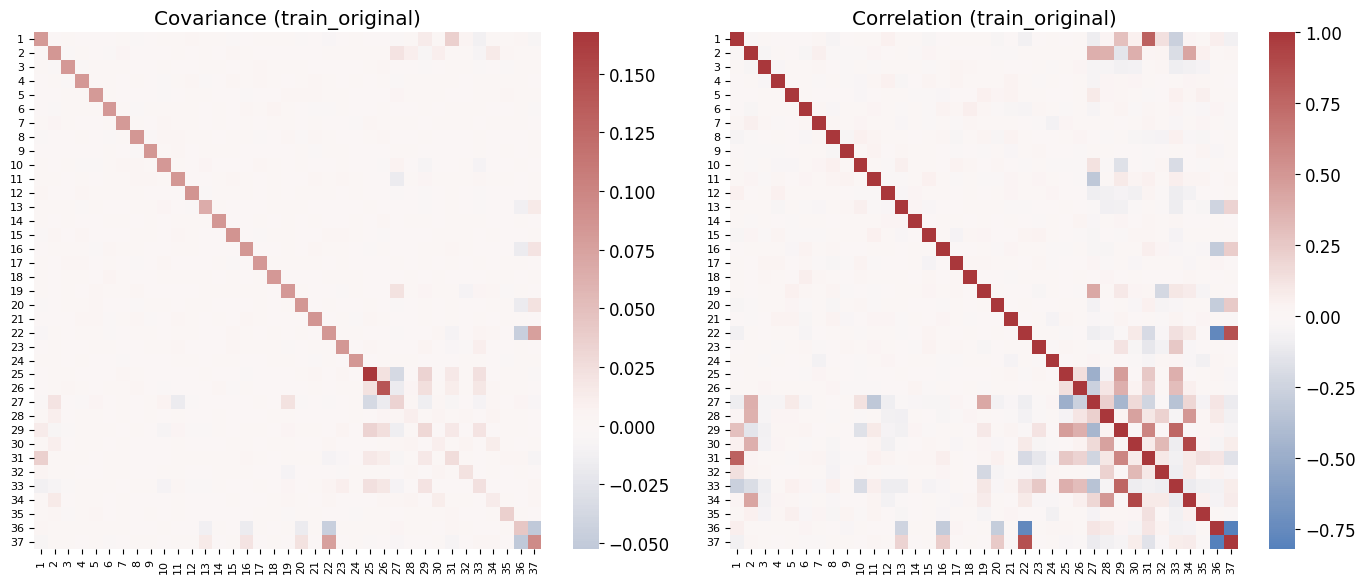

In [24]:
# Compute covariance matrix for `train_original.csv` and show top covarying feature pairs
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

path = r"c:\sources\2155-CP3\dataset\train_original.csv"
print('Loading:', path)
df = pd.read_csv(path)

# Select feature columns (expect names like 'Feature 1'..'Feature 37')
feature_cols = [c for c in df.columns if 'Feature' in c]
if len(feature_cols) < 37:
    # fallback: use numeric columns
    feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()

df_feat = df[feature_cols].apply(pd.to_numeric, errors='coerce')
print('Raw data shape:', df.shape, '-> feature matrix shape:', df_feat.shape)

# Drop rows with all-NaN in features (if any)
df_feat = df_feat.dropna(how='all')

# Compute covariance and correlation
cov = df_feat.cov()
corr = df_feat.corr()

print('Covariance matrix shape:', cov.shape)

# Top absolute corr pairs (upper triangle, excluding diagonal)
n = corr.shape[0]
pairs = []
for i in range(n):
    for j in range(i+1, n):
        pairs.append((feature_cols[i], feature_cols[j], corr.iat[i, j]))
pairs_sorted = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)
print('\nTop 15 absolute correlation pairs:')
for a, b, v in pairs_sorted[:15]:
    print(f'{a} <-> {b}: {v:.6f}')

# Ensure outputs dir exists
out_dir = r"c:\sources\2155-CP3\outputs"
os.makedirs(out_dir, exist_ok=True)
cov_path = os.path.join(out_dir, 'train_covariance.csv')
cov.to_csv(cov_path)
print('\nSaved covariance matrix to', cov_path)

# Plot heatmap (show correlation and covariance side-by-side)
# Use numeric tick labels (1..N) and smaller font size for clarity
labels = [str(i+1) for i in range(len(feature_cols))]
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cov, xticklabels=labels, yticklabels=labels, cmap='vlag', center=0)
plt.title('Covariance (train_original)')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.subplot(1, 2, 2)
sns.heatmap(corr, xticklabels=labels, yticklabels=labels, cmap='vlag', center=0)
plt.title('Correlation (train_original)')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


In [25]:
# VAE Training (fixed for improved VAE signature)
# This cell adapts the training loop to the improved VAE which returns
# (recon_mu, recon_logvar, recon_cat_logits, mu, logvar).
# It defines a local loss function and training loop using the user's config.

import os
import math
import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# --- Utilities ---

def get_beta_schedule(epoch, num_epochs, schedule='cosine', beta_initial=1.0, beta_final=1.0):
    # Simple beta schedule fallback. If you already have a function defined,
    # this will behave similarly for typical settings.
    if schedule == 'linear':
        return beta_initial + (beta_final - beta_initial) * (epoch / max(1, num_epochs - 1))
    if schedule == 'cosine':
        # Smooth cosine interpolation between beta_initial and beta_final
        t = epoch / max(1, num_epochs - 1)
        cos = (1 + math.cos(math.pi * (1 - t))) / 2.0
        return beta_final + (beta_initial - beta_final) * cos
    return beta_initial


def vae_mixed_loss(recon_mu, recon_logvar, recon_cat_logits, x, mask, mu, logvar, cat_feature_idxs, kl_weight=1.0):
    """Return (total_loss, cont_loss, cat_loss, kl)

    - recon_mu, recon_logvar: tensors shape (B, D)
    - recon_cat_logits: dict idx -> (B, C_i)
    - x: (B, D)
    - mask: (B, D) with 1=observed, 0=missing
    - mu, logvar: latent params
    - cat_feature_idxs: list of int indices for categorical features
    - kl_weight: multiplier for KL term
    """
    device = x.device
    mask_f = mask.float()

    # Continuous heteroscedastic NLL (observed entries only)
    var = torch.exp(recon_logvar)
    nll = 0.5 * (((x - recon_mu) ** 2) / var + recon_logvar + math.log(2 * math.pi))
    obs_count = mask_f.sum().clamp(min=1.0)
    cont_loss = (nll * mask_f).sum() / obs_count

    # Categorical cross-entropy for observed categorical positions
    cat_loss = torch.tensor(0.0, device=device)
    cat_count = 0
    for idx in cat_feature_idxs:
        logits = recon_cat_logits[int(idx)]  # (B, C)
        # Build integer targets robustly from stored floats {0.0,0.5,1.0}
        raw = x[:, idx]
        targets = torch.zeros_like(raw, dtype=torch.long, device=device)
        targets = torch.where((raw - 0.5).abs() < (raw - 0.0).abs(), torch.ones_like(targets), targets)
        targets = torch.where((raw - 1.0).abs() < (raw - 0.5).abs(), torch.full_like(targets, 2), targets)
        obs = (mask[:, idx] == 1)
        if obs.sum() > 0:
            cat_loss = cat_loss + F.cross_entropy(logits[obs], targets[obs])
            cat_count += obs.sum().item()
    # If there were categorical observations, average the categorical loss
    if cat_count > 0:
        cat_loss = cat_loss

    # KL term (mean over batch)
    kl = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))

    total = cont_loss + cat_loss + kl_weight * kl
    return total, cont_loss, cat_loss, kl

# --- Training configuration (reuse existing `config` if available) ---
# If `config` is in the notebook global scope (as in your snippet), use it.
try:
    cfg = config
except NameError:
    # Minimal fallback config
    cfg = {
        'input_dim': 37,
        'latent_dim': 128,
        'hidden_dims': [512, 256, 128],
        'use_residual': True,
        'dropout_rate': 0.3,
        'learning_rate': 1e-3,
        'num_epochs': 50,
        'beta_initial': 1.0,
        'beta_schedule': 'cosine',
        'patience': 15,
    }

# Device (reuse notebook device variable if present)
try:
    device = device
except NameError:
    device = torch.device('cpu')

# Use train_loader/val_loader existing in notebook
if 'train_loader' not in globals() or 'val_loader' not in globals():
    raise RuntimeError('`train_loader` and `val_loader` must be defined in the notebook before running this cell.')

# Initialize model (reuse `model` if present and compatible)
model = VAE(
    input_dim=cfg['input_dim'],
    latent_dim=cfg.get('latent_dim', 128),
    hidden_dims=cfg.get('hidden_dims', [512, 256, 128]),
    use_residual=cfg.get('use_residual', True),
    dropout_rate=cfg.get('dropout_rate', 0.1),
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=cfg.get('learning_rate', 1e-3), weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2, eta_min=1e-6)

# Tracking
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

# Training loop (does not automatically run long training; use config['num_epochs'])
num_epochs = cfg.get('num_epochs', 50)
print(f"Starting training for {num_epochs} epochs on device {device}")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_recon = 0.0
    epoch_cat = 0.0
    epoch_kl = 0.0

    beta = get_beta_schedule(epoch, num_epochs, cfg.get('beta_schedule', 'cosine'), cfg.get('beta_initial', 1.0))

    for batch_data, batch_mask in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
        batch_data = batch_data.to(device)
        batch_mask = batch_mask.to(device)

        optimizer.zero_grad()

        recon_mu, recon_logvar, recon_cat_logits, mu, logvar = model(batch_data, batch_mask)

        total_loss, cont_loss, cat_loss, kl = vae_mixed_loss(
            recon_mu, recon_logvar, recon_cat_logits, batch_data, batch_mask, mu, logvar,
            cat_feature_idxs=getattr(model, 'cat_feature_idxs', [24, 25]),
            kl_weight=beta,
        )

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += total_loss.item()
        epoch_recon += cont_loss.item()
        epoch_cat += cat_loss.item()
        epoch_kl += kl.item()

    # Scheduler step per epoch
    scheduler.step()

    avg_train_loss = epoch_loss / len(train_loader)
    avg_recon = epoch_recon / len(train_loader)
    avg_cat = epoch_cat / len(train_loader)
    avg_kl = epoch_kl / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_data, batch_mask in val_loader:
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)
            recon_mu, recon_logvar, recon_cat_logits, mu, logvar = model(batch_data, batch_mask)
            total_loss, _, _, _ = vae_mixed_loss(recon_mu, recon_logvar, recon_cat_logits, batch_data, batch_mask, mu, logvar, getattr(model, 'cat_feature_idxs', [24,25]), kl_weight=beta)
            val_loss += total_loss.item()
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        os.makedirs('outputs', exist_ok=True)
        torch.save(model.state_dict(), os.path.join('outputs', 'best_vae_model.pth'))
    else:
        patience_counter += 1

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f'Epoch {epoch+1}/{num_epochs} | Train {avg_train_loss:.4f} (Recon {avg_recon:.4f}, Cat {avg_cat:.4f}, KL {avg_kl:.4f}) | Val {avg_val_loss:.4f} | Beta {beta:.4f} | Patience {patience_counter}')

    if patience_counter >= cfg.get('patience', 15):
        print(f'Early stopping at epoch {epoch+1}')
        break

print('Training finished. Best val loss:', best_val_loss)
print('Best model saved to outputs/best_vae_model.pth')


Starting training for 500 epochs on device cpu


Epoch 1/500 | Train 53.2233 (Recon 0.2563, Cat 0.4925, KL 52.4745) | Val 1.5499 | Beta 1.0000 | Patience 0


Epoch 5/500 | Train 1.4940 (Recon 0.0735, Cat 0.0366, KL 1.3839) | Val 0.0761 | Beta 1.0000 | Patience 1


Epoch 10/500 | Train 1.0043 (Recon -0.0097, Cat 0.0057, KL 1.0083) | Val -0.0360 | Beta 1.0000 | Patience 0


Epoch 15/500 | Train 0.8550 (Recon -0.0635, Cat 0.0030, KL 0.9156) | Val -0.0820 | Beta 1.0000 | Patience 0


Epoch 20/500 | Train 0.7802 (Recon -0.0877, Cat 0.0022, KL 0.8657) | Val -0.1024 | Beta 1.0000 | Patience 2


Epoch 25/500 | Train 0.8366 (Recon -0.0092, Cat 0.0048, KL 0.8410) | Val -0.0291 | Beta 1.0000 | Patience 7


Epoch 30/500 | Train 0.7559 (Recon -0.0346, Cat 0.0024, KL 0.7881) | Val -0.0348 | Beta 1.0000 | Patience 12


Early stopping at epoch 33
Training finished. Best val loss: -0.1046037736038367
Best model saved to outputs/best_vae_model.pth


In [26]:
# Updated evaluation helper: works with improved VAE forward signature
# evaluate_imputation(model, data_loader, device, n_samples=10)
# Returns: imputations (N, n_samples, D), originals (N, D), masks (N, D)

import numpy as np
import torch
import torch.nn.functional as F


def evaluate_imputation(model, data_loader, device, n_samples=10, cat_value_map=None):
    """
    Evaluate model by producing `n_samples` imputations per example from the model's
    predictive outputs. Works with improved VAE that returns
    (recon_mu, recon_logvar, recon_cat_logits, mu, logvar).

    - model: torch.nn.Module
    - data_loader: yields (batch_data, batch_mask) tensors
    - device: torch.device
    - n_samples: number of imputed draws per example
    - cat_value_map: list/array mapping class ids to stored float values (default [0.0,0.5,1.0])

    Returns (imputations, originals, masks)
      - imputations: np.array shape (N, n_samples, D)
      - originals: np.array shape (N, D)
      - masks: np.array shape (N, D) with 1=observed
    """
    model.eval()
    if cat_value_map is None:
        cat_value_map = np.array([0.0, 0.5, 1.0])

    all_imputations = []
    all_originals = []
    all_masks = []

    with torch.no_grad():
        for batch_data, batch_mask in data_loader:
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)

            # Model forward (improved signature)
            recon_mu, recon_logvar, recon_cat_logits, mu, logvar = model(batch_data, batch_mask)

            B, D = batch_data.shape
            batch_samples = np.zeros((B, n_samples, D), dtype=float)

            # Precompute categorical sampling probabilities per categorical index
            cat_probs = {}
            for idx in getattr(model, 'cat_feature_idxs', []):
                logits = recon_cat_logits[int(idx)]  # (B, C)
                probs = F.softmax(logits, dim=1)
                cat_probs[int(idx)] = probs

            for s in range(n_samples):
                # Continuous sample from predicted heteroscedastic Gaussian
                std = torch.exp(0.5 * recon_logvar)
                eps = torch.randn_like(recon_mu)
                cont_sample = recon_mu + eps * std

                imputed = batch_data.clone()
                miss = (batch_mask == 0)
                # Replace missing continuous positions
                imputed[miss] = cont_sample[miss]

                # Categorical sampling
                # Prepare a tensor of mapped class values matching imputed dtype
                mapped_values_tensor = torch.from_numpy(np.asarray(cat_value_map)).to(device).to(imputed.dtype)

                for idx, probs in cat_probs.items():
                    # probs: (B, C)
                    sampled_cls = torch.multinomial(probs, num_samples=1).squeeze(1)  # (B,)
                    # Map sampled class ids to stored values, dtype-matched
                    mapped_vals = mapped_values_tensor[sampled_cls]
                    miss_idx = (miss[:, idx])
                    if miss_idx.any():
                        # Ensure indices and tensors are on same device and dtype
                        imputed[miss_idx, idx] = mapped_vals[miss_idx]

                batch_samples[:, s, :] = imputed.cpu().numpy()

            all_imputations.append(batch_samples)
            all_originals.append(batch_data.cpu().numpy())
            all_masks.append(batch_mask.cpu().numpy())

    imputations = np.concatenate(all_imputations, axis=0)
    originals = np.concatenate(all_originals, axis=0)
    masks = np.concatenate(all_masks, axis=0)

    return imputations, originals, masks

print('Inserted updated evaluate_imputation(...) compatible with improved VAE.')

Inserted updated evaluate_imputation(...) compatible with improved VAE.


In [27]:
# -------------------------
# MODEL EVALUATION (compatible with improved VAE)
# -------------------------
print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

# Number of imputation samples to draw per example
n_impute_samples = 50

print("Evaluating model on test set...")
# evaluate_imputation returns (N, n_samples, D), originals (N,D), masks (N,D)
test_imputations, test_originals, test_masks = evaluate_imputation(
    model, test_loader, device, n_samples=n_impute_samples
)

print(f"✓ Test set evaluation completed")
print(f"  - Test samples (rows): {test_imputations.shape[0]}")
print(f"  - Samples per row: {test_imputations.shape[1]}")
print(f"  - Features: {test_imputations.shape[2]}")

# Convert to point-estimate imputations by averaging across imputation draws
# Shape: mean_imputations -> (N, D)
mean_imputations = np.nanmean(test_imputations, axis=1)

# Originals and masks
originals = test_originals
masks = test_masks

# If there's a separate X_test_original in the notebook, prefer it for ground truth
try:
    X_test_original
except NameError:
    X_test_original = originals

print("\nCalculating comprehensive metrics...")
from sklearn.metrics import mean_squared_error, mean_absolute_error

feature_metrics = {}

# Create missing mask: True where values were missing and thus were imputed
missing_mask = (masks == 0)

num_features = mean_imputations.shape[1]
for i in range(num_features):
    feature_name = feature_names[i] if 'feature_names' in globals() and len(feature_names) > i else f'Feature_{i+1}'
    miss_idx = missing_mask[:, i]
    n_missing = int(miss_idx.sum())
    if n_missing > 0:
        imputed_missing = mean_imputations[miss_idx, i]
        ground_truth_missing = X_test_original[miss_idx, i]

        # Filter NaNs if present
        valid = ~np.isnan(ground_truth_missing)
        if valid.sum() == 0:
            continue
        imputed_missing = imputed_missing[valid]
        ground_truth_missing = ground_truth_missing[valid]

        mse = mean_squared_error(ground_truth_missing, imputed_missing)
        mae = mean_absolute_error(ground_truth_missing, imputed_missing)

        # Correlation (robust)
        try:
            corr = np.corrcoef(ground_truth_missing, imputed_missing)[0, 1]
        except Exception:
            corr = np.nan

        # Mean difference and Jensen-Shannon divergence (uses existing util)
        try:
            mean_diff, js_div = calculate_jsd_and_mean_diff(imputed_missing, ground_truth_missing, feature_name)
        except Exception:
            mean_diff, js_div = np.nan, np.nan

        feature_metrics[feature_name] = {
            'n_missing': n_missing,
            'mse': float(mse),
            'mae': float(mae),
            'correlation': float(corr) if not np.isnan(corr) else np.nan,
            'mean_difference': float(mean_diff) if not np.isnan(mean_diff) else np.nan,
            'js_divergence': float(js_div) if not np.isnan(js_div) else np.nan,
        }

print(f"✓ Metrics calculated for {len(feature_metrics)} features with missing values")

# Display metrics for last 4 features (or fewer if not available)
print("\n" + "="*100)
print("METRICS FOR LAST 4 FEATURES")
print("="*100)
print(f"{'Feature':<20} {'N_Miss':<8} {'MSE':<12} {'MAE':<12} {'Corr':<8} {'Mean_Diff':<12} {'JS_Div':<8}")
print("-" * 100)

last_features = list(feature_metrics.keys())[-4:]
for feature in last_features:
    m = feature_metrics[feature]
    corr_str = f"{m['correlation']:.3f}" if not np.isnan(m['correlation']) else 'nan'
    mean_diff_str = f"{m['mean_difference']:.4f}" if not np.isnan(m['mean_difference']) else 'nan'
    js_str = f"{m['js_divergence']:.4f}" if not np.isnan(m['js_divergence']) else 'nan'
    print(f"{feature:<20} {m['n_missing']:<8} {m['mse']:<12.4f} {m['mae']:<12.4f} {corr_str:<8} {mean_diff_str:<12} {js_str:<8}")

# Summary statistics
vals_mse = [v['mse'] for v in feature_metrics.values() if not np.isnan(v['mse'])]
vals_mae = [v['mae'] for v in feature_metrics.values() if not np.isnan(v['mae'])]
vals_corr = [v['correlation'] for v in feature_metrics.values() if not np.isnan(v['correlation'])]
vals_mean_diff = [v['mean_difference'] for v in feature_metrics.values() if not np.isnan(v['mean_difference'])]
vals_js = [v['js_divergence'] for v in feature_metrics.values() if not np.isnan(v['js_divergence'])]

def safe_stats(arr):
    if len(arr) == 0:
        return (np.nan, np.nan)
    return (np.mean(arr), np.std(arr))

mse_mean, mse_std = safe_stats(vals_mse)
mae_mean, mae_std = safe_stats(vals_mae)
corr_mean, corr_std = safe_stats(vals_corr)
md_mean, md_std = safe_stats(vals_mean_diff)
js_mean, js_std = safe_stats(vals_js)

print("\nSummary Statistics Across All Features:")
print(f"  - Average MSE: {mse_mean:.4f} ± {mse_std:.4f}")
print(f"  - Average MAE: {mae_mean:.4f} ± {mae_std:.4f}")
print(f"  - Average Correlation: {corr_mean:.3f} ± {corr_std:.3f}")
print(f"  - Average Mean Difference: {md_mean:.4f} ± {md_std:.4f}")
print(f"  - Average JS Divergence: {js_mean:.4f} ± {js_std:.4f}")



MODEL EVALUATION
Evaluating model on test set...
✓ Test set evaluation completed
  - Test samples (rows): 375
  - Samples per row: 50
  - Features: 37

Calculating comprehensive metrics...
✓ Metrics calculated for 37 features with missing values

METRICS FOR LAST 4 FEATURES
Feature              N_Miss   MSE          MAE          Corr     Mean_Diff    JS_Div  
----------------------------------------------------------------------------------------------------
Feature 34           75       0.0132       0.0939       0.080    0.0064       0.5272  
Feature 35           75       0.0395       0.1630       0.029    0.0174       0.5242  
Feature 36           75       0.0456       0.1649       0.028    0.0260       0.5630  
Feature 37           75       0.0839       0.2418       0.089    0.0037       0.6408  

Summary Statistics Across All Features:
  - Average MSE: 0.0791 ± 0.0467
  - Average MAE: 0.2254 ± 0.0687
  - Average Correlation: 0.063 ± 0.162
  - Average Mean Difference: 0.0464 ± 0.05

In [28]:
# Utility: generate_samples_vae
# Produces N x S x D samples from the improved VAE (heteroscedastic continuous + categorical logits)

import numpy as np
import torch
import torch.nn.functional as F


def generate_samples_vae(model, data_loader, device, n_samples_per_test=50, cat_value_map=None, save_path=None):
    """
    Generate multiple imputed samples per row using the improved VAE.

    Args:
        model: trained VAE (forward -> recon_mu, recon_logvar, recon_cat_logits, mu, logvar)
        data_loader: yields (batch_data, batch_mask)
        device: torch.device
        n_samples_per_test: int
        cat_value_map: array-like mapping class ids -> stored float values (default [0.0,0.5,1.0])
        save_path: optional path (npz) to save results {imputations, originals, masks}

    Returns:
        imputations: np.ndarray shape (N, S, D)
        originals: np.ndarray shape (N, D)
        masks: np.ndarray shape (N, D)
    """
    model.eval()
    if cat_value_map is None:
        cat_value_map = np.array([0.0, 0.5, 1.0])

    all_imputations = []
    all_originals = []
    all_masks = []

    with torch.no_grad():
        for batch_data, batch_mask in data_loader:
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)

            # Forward once to get predictive parameters
            recon_mu, recon_logvar, recon_cat_logits, mu, logvar = model(batch_data, batch_mask)

            B, D = batch_data.shape
            batch_samples = np.zeros((B, n_samples_per_test, D), dtype=float)

            # Precompute categorical probabilities and mapped values tensor (dtype-matched)
            cat_probs = {}
            cat_idxs = getattr(model, 'cat_feature_idxs', [])
            for idx in cat_idxs:
                logits = recon_cat_logits[int(idx)]  # (B, C)
                probs = F.softmax(logits, dim=1)
                cat_probs[int(idx)] = probs

            mapped_values_tensor = torch.from_numpy(np.asarray(cat_value_map)).to(device)

            for s in range(n_samples_per_test):
                # Sample continuous values from predicted heteroscedastic Gaussian
                std = torch.exp(0.5 * recon_logvar)
                eps = torch.randn_like(recon_mu)
                cont_sample = recon_mu + eps * std

                imputed = batch_data.clone()
                miss = (batch_mask == 0)
                # Replace missing continuous positions
                imputed[miss] = cont_sample[miss]

                # Categorical sampling: ensure mapped values have same dtype as `imputed`
                mapped_values_tensor_cast = mapped_values_tensor.to(dtype=imputed.dtype)

                for idx, probs in cat_probs.items():
                    sampled_cls = torch.multinomial(probs, num_samples=1).squeeze(1)  # (B,)
                    mapped_vals = mapped_values_tensor_cast[sampled_cls]
                    miss_idx = (miss[:, idx])
                    if miss_idx.any():
                        imputed[miss_idx, idx] = mapped_vals[miss_idx]

                batch_samples[:, s, :] = imputed.cpu().numpy()

            all_imputations.append(batch_samples)
            all_originals.append(batch_data.cpu().numpy())
            all_masks.append(batch_mask.cpu().numpy())

    imputations = np.concatenate(all_imputations, axis=0)
    originals = np.concatenate(all_originals, axis=0)
    masks = np.concatenate(all_masks, axis=0)

    if save_path is not None:
        np.savez_compressed(save_path, imputations=imputations, originals=originals, masks=masks)
        print(f'Saved samples to {save_path}')

    return imputations, originals, masks

print('Inserted generate_samples_vae(...)')

Inserted generate_samples_vae(...)


In [29]:
# -------------------------
# TEST EVALUATION (uses generate_samples_vae)
# -------------------------
print("="*70)
print("TEST EVALUATION")
print("="*70)

# How many samples per test row to generate
n_samples_per_row = 100

# Ensure outputs dir exists
import os
os.makedirs('outputs', exist_ok=True)

# Note: `generate_samples_vae` expects a DataLoader (yields (batch_data, batch_mask)).
# If you have a DataLoader named `test_loader`, use it. If you only have an array `X_test`,
# create a DataLoader that yields (X_test_batch, mask_batch) before running this cell.

# Prefer existing `test_loader` in the notebook
if 'test_loader' not in globals():
    raise RuntimeError("`test_loader` not found in the notebook. Create a DataLoader that yields (batch_data, batch_mask) and name it `test_loader`.")

print(f"Generating {n_samples_per_row} samples per test row using `generate_samples_vae`...")
imputations, originals, masks = generate_samples_vae(
    model=model,
    data_loader=test_loader,
    device=device,
    n_samples_per_test=n_samples_per_row,
    save_path=os.path.join('outputs', f'test_imputations_vae_{n_samples_per_row}.npz')
)

print('\nDone.')
print(f'  - Imputations shape: {imputations.shape}  (N, S, D)')
print(f'  - Originals shape:   {originals.shape}  (N, D)')
print(f'  - Masks shape:       {masks.shape}  (N, D)')


TEST EVALUATION
Generating 100 samples per test row using `generate_samples_vae`...
Saved samples to outputs\test_imputations_vae_100.npz

Done.
  - Imputations shape: (375, 100, 37)  (N, S, D)
  - Originals shape:   (375, 37)  (N, D)
  - Masks shape:       (375, 37)  (N, D)


In [30]:
test_score = compute_score(generated_samples=imputations, set_name='test')
print("Test score:", test_score)

Loading data...
Found data in current directory
Test data shape: (375, 37)
Missing ratio: 20.0%
Generated samples shape: (375, 100, 37)

📊 EVALUATION RESULTS
Missing values evaluated: 2,775
MSE          : 0.0782
MAE          : 0.2235
Correlation  : 0.293
JS Divergence: 0.1417

📈 FEATURE-WISE RESULTS
Feature  MSE        MAE        Corr     JSDiv    Count   
0        0.0944     0.2602     0.070    0.4524   75      
1        0.1041     0.2848     0.113    0.4166   75      
2        0.0753     0.2315     -0.000   0.3760   75      
3        0.0971     0.2699     -0.066   0.3929   75      
4        0.0977     0.2742     -0.053   0.4515   75      
5        0.0786     0.2462     -0.106   0.5009   75      
6        0.0900     0.2634     0.114    0.4512   75      
7        0.0810     0.2367     -0.088   0.4418   75      
8        0.0991     0.2701     -0.167   0.3896   75      
9        0.0961     0.2660     -0.029   0.4148   75      
10       0.0805     0.2459     0.056    0.4098   75      
11 

In [31]:
# Transformer + Diffusers setup for tabular diffusion imputation
# 1) (Optional) Install dependencies in notebook (run if needed):
# !pip install --upgrade pip
# !pip install diffusers[torch] transformers accelerate --quiet

# 2) Imports and Transformer denoiser definition
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from diffusers import DDPMScheduler

class TransformerDenoiser(nn.Module):
    """Transformer-based denoiser for tabular DDPM.

    Treats each feature as a token. Inputs:
      - noisy_x: (B, D) real values
      - cond_x: (B, D) observed values (or the same noisy_x)
      - mask: (B, D) 1=observed, 0=missing
      - t: tensor of timesteps (B,)

    Outputs predicted noise of shape (B, D)
    """
    def __init__(self, num_features, emb_dim=128, n_layers=6, n_heads=8, ff_dim=512, time_dim=128, dropout=0.1):
        super().__init__()
        self.num_features = num_features
        self.emb_dim = emb_dim

        # token projection: project scalar feature value -> embedding
        self.token_proj = nn.Linear(1, emb_dim)

        # small embedding for mask and conditional observed values
        self.mask_proj = nn.Linear(1, emb_dim)
        self.cond_proj = nn.Linear(1, emb_dim)

        # timestep embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_dim),
            nn.ReLU(),
            nn.Linear(time_dim, emb_dim),
        )

        # positional embeddings for tokens (features)
        self.pos_emb = nn.Parameter(torch.randn(1, num_features, emb_dim))

        # Transformer encoder stack
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=dropout, activation='gelu')
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # output projection back to scalar per token (predict noise)
        self.out = nn.Linear(emb_dim, 1)

        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.token_proj.weight)
        nn.init.xavier_uniform_(self.cond_proj.weight)
        nn.init.xavier_uniform_(self.mask_proj.weight)
        nn.init.xavier_uniform_(self.out.weight)

    def forward(self, noisy_x, cond_x, mask, t):
        # noisy_x, cond_x: (B, D); mask: (B, D); t: (B,) or int
        B, D = noisy_x.shape
        device = noisy_x.device

        # Project scalars to embeddings
        noisy_emb = self.token_proj(noisy_x.unsqueeze(-1))  # (B, D, emb_dim)
        cond_emb = self.cond_proj(cond_x.unsqueeze(-1))
        mask_emb = self.mask_proj(mask.unsqueeze(-1).float())

        # timestep embedding, broadcast to tokens
        if isinstance(t, int):
            t_tensor = torch.full((B, 1), float(t), device=device)
        else:
            t_tensor = t.float().unsqueeze(-1)
        time_emb = self.time_mlp(t_tensor)  # (B, emb_dim)
        time_emb = time_emb.unsqueeze(1).expand(-1, D, -1)

        x = noisy_emb + cond_emb + mask_emb + time_emb + self.pos_emb

        # Transformer expects shape (seq_len, batch, emb_dim)
        x = x.permute(1, 0, 2)
        x = self.transformer(x)  # (D, B, emb_dim)
        x = x.permute(1, 0, 2)  # (B, D, emb_dim)

        out = self.out(x).squeeze(-1)  # (B, D)
        return out

# 3) Diffusion training + sampling helpers using diffusers' scheduler
class TransformerDiffusionImputer:
    def __init__(self, denoiser: nn.Module, num_train_timesteps=1000, beta_schedule='linear', device='cpu'):
        self.denoiser = denoiser
        self.device = device
        self.num_train_timesteps = num_train_timesteps
        # Use diffusers scheduler for betas/schedule management
        if beta_schedule == 'linear':
            self.scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps, beta_schedule='linear')
        else:
            # fallback to default linear
            self.scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps, beta_schedule='linear')

        # move model
        self.denoiser.to(device)

    def p_losses(self, x_start, cond_x, mask, t, noise=None):
        # x_start: (B, D)
        if noise is None:
            noise = torch.randn_like(x_start)
        # Use scheduler helper to produce noisy sample
        noisy = self.scheduler.add_noise(x_start, noise, t)
        noisy = noisy.to(self.device)
        cond_x = cond_x.to(self.device)
        mask = mask.to(self.device)

        # Predict noise with denoiser
        pred_noise = self.denoiser(noisy, cond_x, mask, t)

        # Loss computed only on missing positions (we want to impute missing entries)
        loss = F.mse_loss(pred_noise * (1 - mask), noise * (1 - mask))
        return loss

    @torch.no_grad()
    def sample(self, cond_x, mask, batch_size=64, device=None):
        device = device or self.device
        self.denoiser.eval()
        B, D = cond_x.shape
        # Start from standard normal
        sample = torch.randn((B, D), device=device)

        for i in reversed(range(self.scheduler.num_train_timesteps)):
            t = torch.full((B,), i, device=device, dtype=torch.long)
            pred_noise = self.denoiser(sample, cond_x.to(device), mask.to(device), t)
            # scheduler.step expects model_output and returns prev_sample
            step_output = self.scheduler.step(model_output=pred_noise, timestep=i, sample=sample)
            prev_sample = step_output.prev_sample
            # Re-impose observed values after the denoising step
            prev_sample = prev_sample * (1 - mask.to(device)) + cond_x.to(device) * mask.to(device)
            sample = prev_sample
        return sample.cpu().numpy()

# 4) Example training loop (short-run template)
# Usage notes:
#  - You must have train_loader/val_loader yielding (batch_data, batch_mask) already defined
#  - cond_x is the batch_data where observed entries are used by the model; mask indicates observed
#
# Example hyperparameters and training skeleton (do not run long training automatically):

print('Inserted Transformer-based diffusion imputer (definition + helpers).')


Inserted Transformer-based diffusion imputer (definition + helpers).
